# Validation curves
In this notebook we will try to train an estimator over the training data, and every epoch, perform a evaluation on both the training data and the validation data. With this data we will plot the validation curves of the algorithm. 

We will also try to implement a mechanism to persist and restorethe model which achieved the best performance overall on the validation set and at the end use it to evaluate the model's generalization ability on the test set.

In [1]:
%matplotlib inline
# standard library
import itertools
import sys, os
import re
import glob
import shutil

# pandas
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import dask


# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# skealrn
from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score
from sklearn.utils import class_weight


# tesnsorflow
import tensorflow as tf

# local imports
sys.path.append(os.path.join(os.getcwd(), "../src"))

import tf_utils, tf_experiments

# this styling is purely my preference
# less chartjunk
sns.set_context('notebook', font_scale=1.5, rc={'line.linewidth': 2.5})
sns.set(style='ticks', palette='Set2')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# define some constants
RANDOM_SEED = 42
BEST_CHECKPOINT_PATH = '/home/nikitautiu/models/best/best_cleaneval2.ckpt'
MODEL_DIR = '/home/nikitautiu/models/cleaneval_curves2/'

## Inputting the data
Using our in-memory caching dataset, we are going to load all the 3 datasets(train, validation, test) in memory.

In [3]:
# get the input functions and the initialization hooks to pass to the estimator
data_X, data_y, split_slices = tf_utils.get_numpy_datasets('../data/final/cleaneval/')

Compute the balanced class weights using `sklearn` utils. It guarantees weight balance.

In [4]:
cls_weights = class_weight.compute_class_weight('balanced', [0, 1], data_y[split_slices[0]])
weights = data_y * cls_weights[1] + (~data_y * cls_weights[0])

Use numpy input to make input functions to ffeed to our estimator.

In [5]:
train_train_fn = tf.estimator.inputs.numpy_input_fn(x={'data': data_X[split_slices[0]], 'weights': weights[split_slices[0]]},
                                                    y=data_y[split_slices[0]], 
                                                    shuffle=True, num_epochs=1, batch_size=2000, queue_capacity=4000)
train_eval_fn = tf.estimator.inputs.numpy_input_fn(x={'data': data_X[split_slices[0]], 'weights': weights[split_slices[0]]},
                                                    y=data_y[split_slices[0]], 
                                                    shuffle=False, num_epochs=1, batch_size=2000, queue_capacity=4000)
validation_fn = tf.estimator.inputs.numpy_input_fn(x={'data': data_X[split_slices[1]], 'weights': weights[split_slices[1]]},
                                                        y=data_y[split_slices[1]], 
                                                        shuffle=False, num_epochs=1, batch_size=2000, queue_capacity=4000)
test_fn = tf.estimator.inputs.numpy_input_fn(x={'data': data_X[split_slices[2]], 'weights': weights[split_slices[2]]}, 
                                                   y=data_y[split_slices[2]], 
                                                   shuffle=False, num_epochs=1, batch_size=2000, queue_capacity=4000)

## Defining the model


In [6]:
# # session workaround
# sess_config = tf.ConfigProto()
# sess_config.gpu_options.allow_growth = True

config = tf.estimator.RunConfig(
    model_dir=MODEL_DIR,
#     save_checkpoints_steps=10, 
#     session_config=sess_config, 
    tf_random_seed=RANDOM_SEED
)

# we can infer the columns from the function, a bit costly, but better than hardcoding
tf_feat_cols = tf.contrib.learn.infer_real_valued_columns_from_input_fn(train_eval_fn)
estimator = tf.estimator.DNNClassifier(feature_columns=tf_feat_cols, hidden_units=(1000, 500, 200), 
                                        weight_column='weights', config=config)


INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_log_step_count_steps': 100, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_master': '', '_keep_checkpoint_every_n_hours': 10000, '_num_worker_replicas': 1, '_model_dir': '/home/nikitautiu/models/cleaneval_curves2/', '_save_checkpoints_steps': None, '_tf_random_seed': 42, '_task_type': 'worker', '_task_id': 0, '_session_config': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f684f2ed320>, '_service': None}


Now that we have the model, we can build the infrastructure  for testing out the training process and returning the losses and other metrics.

## Train loop
We are running the train/eval loop for 1500 epochs. The best models for validation are persisted

In [7]:
metrics = tf_experiments.train_eval_loop(
    estimator=estimator, 
    train_input_fn=train_train_fn,
    num_epochs=1500,
    eval_input_fns={'train': train_eval_fn, 'validation': validation_fn},
    save_on_metric='f1-score', best_checkpoint_path=BEST_CHECKPOINT_PATH, save_set_name='validation'
)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 464701.7, step = 1
INFO:tensorflow:global_step/sec: 7.28519
INFO:tensorflow:loss = 1232206.1, step = 101 (13.727 sec)
INFO:tensorflow:Saving checkpoints for 116 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 92544.414.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-116
validation  ----  {'support': 4106, 'f1-score': 0.18846914061412545, 'epoch': 1, 'recall': 0.8244033122260107, 'accuracy': 0.5167915395836096, 'support_other': 56222, 'precision': 0.1063963539211064}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-116
train  ----  {'support': 21849, 'f1-score': 0.26362212868655815, 'epoch': 1, 'recall': 0.8399011396402581, 'accuracy': 0.5559713451660127, 'support_other':

validation  ----  {'support': 4106, 'f1-score': 0.29976635514018696, 'epoch': 7, 'recall': 0.6249391134924501, 'accuracy': 0.8012863015515184, 'support_other': 56222, 'precision': 0.1971722760104503}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-812
train  ----  {'support': 21849, 'f1-score': 0.4256638664937701, 'epoch': 7, 'recall': 0.6911071444917387, 'accuracy': 0.8235146349280598, 'support_other': 209037, 'precision': 0.3075419051304507}
F1-SCORE OF 0.29976635514018696 BETTER THAN LAST VALUE OF 0.2829939944338656 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-812
INFO:tensorflow:Saving checkpoints for 813 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 6112.425, step = 813
INFO:tensorflow:global_step/sec: 7.23269
INFO:tensorflow:loss = 71236.44, step = 913 (13.827 sec)
INFO:tensorflow:Saving checkp

INFO:tensorflow:Saving checkpoints for 1509 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 7320.1597, step = 1509
INFO:tensorflow:global_step/sec: 7.27362
INFO:tensorflow:loss = 32827.547, step = 1609 (13.749 sec)
INFO:tensorflow:Saving checkpoints for 1624 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 1853.3789.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-1624
validation  ----  {'support': 4106, 'f1-score': 0.24794648149716317, 'epoch': 14, 'recall': 0.7131027764247443, 'accuracy': 0.7055761835300358, 'support_other': 56222, 'precision': 0.15006150061500614}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-1624
train  ----  {'support': 21849, 'f1-score': 0.33601692877410666, 'epoch': 14, 'recall': 0.7994416220421987, 'accuracy': 0.7010169520889097, 'support_other': 209037, 'precision': 0.212711

train  ----  {'support': 21849, 'f1-score': 0.3727818045488628, 'epoch': 20, 'recall': 0.819167925305506, 'accuracy': 0.7391439931394714, 'support_other': 209037, 'precision': 0.24129423660262891}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-2320
INFO:tensorflow:Saving checkpoints for 2321 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 4165.7534, step = 2321
INFO:tensorflow:global_step/sec: 7.22868
INFO:tensorflow:loss = 9071.5, step = 2421 (13.834 sec)
INFO:tensorflow:Saving checkpoints for 2436 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 1211.9445.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-2436
validation  ----  {'support': 4106, 'f1-score': 0.30444468017396836, 'epoch': 21, 'recall': 0.34948855333658063, 'accuracy': 0.8913108341068824, 'sup

INFO:tensorflow:Loss for final step: 2143.8345.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-3132
validation  ----  {'support': 4106, 'f1-score': 0.2718649579929536, 'epoch': 27, 'recall': 0.8550901120311739, 'accuracy': 0.6882542103169341, 'support_other': 56222, 'precision': 0.16162592643741655}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-3132
train  ----  {'support': 21849, 'f1-score': 0.3389218146546354, 'epoch': 27, 'recall': 0.8715730697057074, 'accuracy': 0.6782481397746074, 'support_other': 209037, 'precision': 0.21036177851422258}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-3132
INFO:tensorflow:Saving checkpoints for 3133 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 2391.246, step = 3133
INFO:tensorflow:global_step/sec: 7.25748
INFO:te

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-3828
INFO:tensorflow:Saving checkpoints for 3829 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 1085.0082, step = 3829
INFO:tensorflow:global_step/sec: 7.20849
INFO:tensorflow:loss = 7388.384, step = 3929 (13.873 sec)
INFO:tensorflow:Saving checkpoints for 3944 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 3931.4324.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-3944
validation  ----  {'support': 4106, 'f1-score': 0.20041285455796526, 'epoch': 34, 'recall': 0.9576229907452508, 'accuracy': 0.479926402333908, 'support_other': 56222, 'precision': 0.1119175703754305}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-3944
train  ----  {'support': 21849, 'f1-score': 0.2599216446049429, 'epoch': 34, 'recall': 0.

train  ----  {'support': 21849, 'f1-score': 0.3552218080830227, 'epoch': 40, 'recall': 0.8898347750469129, 'accuracy': 0.6943080134785132, 'support_other': 209037, 'precision': 0.2219026422416253}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-4640
INFO:tensorflow:Saving checkpoints for 4641 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 2086.0037, step = 4641
INFO:tensorflow:global_step/sec: 7.21685
INFO:tensorflow:loss = 1167.1852, step = 4741 (13.857 sec)
INFO:tensorflow:Saving checkpoints for 4756 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 666.0037.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-4756
validation  ----  {'support': 4106, 'f1-score': 0.3110999749436231, 'epoch': 41, 'recall': 0.7559668777398928, 'accuracy': 0.772129027980374, 'supp


EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-5452
validation  ----  {'support': 4106, 'f1-score': 0.37937937937937943, 'epoch': 47, 'recall': 0.6461276181198247, 'accuracy': 0.8561198780002652, 'support_other': 56222, 'precision': 0.26852226720647776}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-5452
train  ----  {'support': 21849, 'f1-score': 0.47732801782995626, 'epoch': 47, 'recall': 0.6959586251087007, 'accuracy': 0.8557686477309149, 'support_other': 209037, 'precision': 0.36322377221479074}
F1-SCORE OF 0.37937937937937943 BETTER THAN LAST VALUE OF 0.37556637019634165 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-5452
INFO:tensorflow:Saving checkpoints for 5453 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 1500.102, step = 5453
INFO:

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-6148
INFO:tensorflow:Saving checkpoints for 6149 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 1203.8618, step = 6149
INFO:tensorflow:global_step/sec: 7.23253
INFO:tensorflow:loss = 1073.5242, step = 6249 (13.827 sec)
INFO:tensorflow:Saving checkpoints for 6264 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 538.0407.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-6264
validation  ----  {'support': 4106, 'f1-score': 0.31779581053028877, 'epoch': 54, 'recall': 0.8202630297126157, 'accuracy': 0.7603103036732529, 'support_other': 56222, 'precision': 0.1970743124634289}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-6264
train  ----  {'support': 21849, 'f1-score': 

validation  ----  {'support': 4106, 'f1-score': 0.3429894464785699, 'epoch': 60, 'recall': 0.7756941061860692, 'accuracy': 0.7977390266542899, 'support_other': 56222, 'precision': 0.2201714364717268}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-6960
train  ----  {'support': 21849, 'f1-score': 0.42064521953035966, 'epoch': 60, 'recall': 0.8530825209391735, 'accuracy': 0.777626187815632, 'support_other': 209037, 'precision': 0.27914395255496316}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-6960
INFO:tensorflow:Saving checkpoints for 6961 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 973.6595, step = 6961
INFO:tensorflow:global_step/sec: 7.25148
INFO:tensorflow:loss = 1035.4377, step = 7061 (13.791 sec)
INFO:tensorflow:Saving checkpoints for 7076 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:t

INFO:tensorflow:loss = 958.564, step = 7657
INFO:tensorflow:global_step/sec: 7.24189
INFO:tensorflow:loss = 1873.8573, step = 7757 (13.809 sec)
INFO:tensorflow:Saving checkpoints for 7772 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 558.5653.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-7772
validation  ----  {'support': 4106, 'f1-score': 0.32632680235875977, 'epoch': 67, 'recall': 0.8356064296151973, 'accuracy': 0.7651836626442117, 'support_other': 56222, 'precision': 0.20275381160619313}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-7772
train  ----  {'support': 21849, 'f1-score': 0.40744174286797863, 'epoch': 67, 'recall': 0.8850748318000824, 'accuracy': 0.7563819374063391, 'support_other': 209037, 'precision': 0.26463222716387275}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/

train  ----  {'support': 21849, 'f1-score': 0.4828971549869645, 'epoch': 73, 'recall': 0.7756876744931118, 'accuracy': 0.8427925469712325, 'support_other': 209037, 'precision': 0.350570908489161}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-8468
INFO:tensorflow:Saving checkpoints for 8469 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 886.3396, step = 8469
INFO:tensorflow:global_step/sec: 7.19968
INFO:tensorflow:loss = 879.1974, step = 8569 (13.890 sec)
INFO:tensorflow:Saving checkpoints for 8584 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 673.4313.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-8584
validation  ----  {'support': 4106, 'f1-score': 0.32852729145211124, 'epoch': 74, 'recall': 0.8546030199707745, 'accuracy': 0.7622331255801618, 'suppo


EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-9280
validation  ----  {'support': 4106, 'f1-score': 0.3991850683491063, 'epoch': 80, 'recall': 0.7396492937165124, 'accuracy': 0.8484617424744729, 'support_other': 56222, 'precision': 0.27335733573357335}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-9280
train  ----  {'support': 21849, 'f1-score': 0.4934843638699945, 'epoch': 80, 'recall': 0.8085495903702686, 'accuracy': 0.8429311435080515, 'support_other': 209037, 'precision': 0.35510975315590576}
F1-SCORE OF 0.3991850683491063 BETTER THAN LAST VALUE OF 0.3965628634190464 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-9280
INFO:tensorflow:Saving checkpoints for 9281 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 793.4949, step = 9281
INFO:tens

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-9976
INFO:tensorflow:Saving checkpoints for 9977 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 756.3174, step = 9977
INFO:tensorflow:global_step/sec: 7.24592
INFO:tensorflow:loss = 1438.1548, step = 10077 (13.801 sec)
INFO:tensorflow:Saving checkpoints for 10092 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 434.68567.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-10092
validation  ----  {'support': 4106, 'f1-score': 0.408044523146977, 'epoch': 87, 'recall': 0.7856794934242571, 'accuracy': 0.8448481633735578, 'support_other': 56222, 'precision': 0.27558516999829147}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-10092
train  ----  {'support': 21849, 'f1-score

validation  ----  {'support': 4106, 'f1-score': 0.3748003744699598, 'epoch': 93, 'recall': 0.8287871407696055, 'accuracy': 0.8118120938867525, 'support_other': 56222, 'precision': 0.24215470006404327}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-10788
train  ----  {'support': 21849, 'f1-score': 0.45783045718197213, 'epoch': 93, 'recall': 0.8724426747219552, 'accuracy': 0.8044619422572179, 'support_other': 209037, 'precision': 0.3103448275862069}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-10788
INFO:tensorflow:Saving checkpoints for 10789 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 1161.7444, step = 10789
INFO:tensorflow:global_step/sec: 7.24372
INFO:tensorflow:loss = 1514.956, step = 10889 (13.806 sec)
INFO:tensorflow:Saving checkpoints for 10904 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.

INFO:tensorflow:Saving checkpoints for 11485 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 817.9629, step = 11485
INFO:tensorflow:global_step/sec: 7.23255
INFO:tensorflow:loss = 1542.6855, step = 11585 (13.827 sec)
INFO:tensorflow:Saving checkpoints for 11600 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 348.37793.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-11600
validation  ----  {'support': 4106, 'f1-score': 0.3929862617498192, 'epoch': 100, 'recall': 0.7942036044812469, 'accuracy': 0.8330128630155151, 'support_other': 56222, 'precision': 0.2610888710968775}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-11600
train  ----  {'support': 21849, 'f1-score': 0.4724136669146976, 'epoch': 100, 'recall': 0.88626481761179, 'accuracy': 0.8126737870637457, 'support_other': 209037, 'precision': 0.3220

train  ----  {'support': 21849, 'f1-score': 0.5281451124537017, 'epoch': 106, 'recall': 0.8582086136665293, 'accuracy': 0.8548850948086935, 'support_other': 209037, 'precision': 0.3814435086862769}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-12296
INFO:tensorflow:Saving checkpoints for 12297 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 751.24164, step = 12297
INFO:tensorflow:global_step/sec: 7.20624
INFO:tensorflow:loss = 751.8476, step = 12397 (13.877 sec)
INFO:tensorflow:Saving checkpoints for 12412 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 415.5674.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-12412
validation  ----  {'support': 4106, 'f1-score': 0.39872525586811297, 'epoch': 107, 'recall': 0.7922552362396493, 'accuracy': 0.83737236440790

INFO:tensorflow:Loss for final step: 382.70935.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-13108
validation  ----  {'support': 4106, 'f1-score': 0.42574641333850327, 'epoch': 113, 'recall': 0.8022406234778373, 'accuracy': 0.8527052115104098, 'support_other': 56222, 'precision': 0.28976073187895846}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-13108
train  ----  {'support': 21849, 'f1-score': 0.5116266730338122, 'epoch': 113, 'recall': 0.8826490914916014, 'accuracy': 0.8405403532479232, 'support_other': 209037, 'precision': 0.3602114386043558}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-13108
INFO:tensorflow:Saving checkpoints for 13109 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 723.8718, step = 13109
INFO:tensorflow:global_step/sec: 7.17304


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-13804
INFO:tensorflow:Saving checkpoints for 13805 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 759.1329, step = 13805
INFO:tensorflow:global_step/sec: 7.12753
INFO:tensorflow:loss = 779.80676, step = 13905 (14.031 sec)
INFO:tensorflow:Saving checkpoints for 13920 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 336.72064.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-13920
validation  ----  {'support': 4106, 'f1-score': 0.464831363505333, 'epoch': 120, 'recall': 0.7854359473940575, 'accuracy': 0.8769062458559873, 'support_other': 56222, 'precision': 0.33009211873080857}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-13920
train  ----  {'support': 21849, 'f1-s

validation  ----  {'support': 4106, 'f1-score': 0.4610091743119267, 'epoch': 126, 'recall': 0.7832440331222601, 'accuracy': 0.8753480970693542, 'support_other': 56222, 'precision': 0.3266301035953687}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-14616
train  ----  {'support': 21849, 'f1-score': 0.5584334461569751, 'epoch': 126, 'recall': 0.879719895647398, 'accuracy': 0.8683462834472424, 'support_other': 209037, 'precision': 0.40904447754841455}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-14616
INFO:tensorflow:Saving checkpoints for 14617 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 740.99036, step = 14617
INFO:tensorflow:global_step/sec: 7.18713
INFO:tensorflow:loss = 665.3634, step = 14717 (13.914 sec)
INFO:tensorflow:Saving checkpoints for 14732 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.

INFO:tensorflow:Saving checkpoints for 15313 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 730.51154, step = 15313
INFO:tensorflow:global_step/sec: 7.21903
INFO:tensorflow:loss = 773.6667, step = 15413 (13.853 sec)
INFO:tensorflow:Saving checkpoints for 15428 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 299.14175.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-15428
validation  ----  {'support': 4106, 'f1-score': 0.4612572071438616, 'epoch': 133, 'recall': 0.7988309790550414, 'accuracy': 0.8729942978384829, 'support_other': 56222, 'precision': 0.32423882957690786}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-15428
train  ----  {'support': 21849, 'f1-score': 0.5497716635131097, 'epoch': 133, 'recall': 0.8843425328390315, 'accuracy': 0.8629323562277488, 'support_other': 209037, 'precision': 0.3

train  ----  {'support': 21849, 'f1-score': 0.5476904454042753, 'epoch': 139, 'recall': 0.9111629822875189, 'accuracy': 0.8575833961348891, 'support_other': 209037, 'precision': 0.39151212413223463}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-16124
INFO:tensorflow:Saving checkpoints for 16125 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 729.26355, step = 16125
INFO:tensorflow:global_step/sec: 7.21181
INFO:tensorflow:loss = 739.5564, step = 16225 (13.867 sec)
INFO:tensorflow:Saving checkpoints for 16240 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 805.6124.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-16240
validation  ----  {'support': 4106, 'f1-score': 0.414635643685923, 'epoch': 140, 'recall': 0.8224549439844131, 'accuracy': 0.841947354462272

INFO:tensorflow:Saving checkpoints for 16936 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 618.08765.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-16936
validation  ----  {'support': 4106, 'f1-score': 0.39576521874513465, 'epoch': 146, 'recall': 0.9286410131514856, 'accuracy': 0.8070050391194802, 'support_other': 56222, 'precision': 0.2514673877201082}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-16936
train  ----  {'support': 21849, 'f1-score': 0.45436460743399576, 'epoch': 146, 'recall': 0.9617373792850932, 'accuracy': 0.7814159368692775, 'support_other': 209037, 'precision': 0.297444971335551}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-16936
INFO:tensorflow:Saving checkpoints for 16937 into /home/nikitautiu/models/cleaneval_curv

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-17632
INFO:tensorflow:Saving checkpoints for 17633 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 666.4662, step = 17633
INFO:tensorflow:global_step/sec: 7.18651
INFO:tensorflow:loss = 636.59863, step = 17733 (13.916 sec)
INFO:tensorflow:Saving checkpoints for 17748 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 322.98816.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-17748
validation  ----  {'support': 4106, 'f1-score': 0.4421891058581705, 'epoch': 153, 'recall': 0.838285435947394, 'accuracy': 0.8560535737965786, 'support_other': 56222, 'precision': 0.3002966323503751}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-17748
train  ----  {'support': 21849, 'f1-sc

train  ----  {'support': 21849, 'f1-score': 0.5538495710358996, 'epoch': 159, 'recall': 0.912993729690146, 'accuracy': 0.8608057656159317, 'support_other': 209037, 'precision': 0.397489289628375}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-18444
INFO:tensorflow:Saving checkpoints for 18445 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 569.2189, step = 18445
INFO:tensorflow:global_step/sec: 7.26269
INFO:tensorflow:loss = 586.08167, step = 18545 (13.770 sec)
INFO:tensorflow:Saving checkpoints for 18560 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 244.31108.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-18560
validation  ----  {'support': 4106, 'f1-score': 0.47605633802816905, 'epoch': 160, 'recall': 0.8231855820750121, 'accuracy': 0.876674181143084

INFO:tensorflow:Loss for final step: 426.48175.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-19256
validation  ----  {'support': 4106, 'f1-score': 0.4718438421570004, 'epoch': 166, 'recall': 0.8183146614710181, 'accuracy': 0.8753149449675109, 'support_other': 56222, 'precision': 0.3314917127071823}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-19256
train  ----  {'support': 21849, 'f1-score': 0.5711546686724777, 'epoch': 166, 'recall': 0.8862190489267243, 'accuracy': 0.8740633905910276, 'support_other': 209037, 'precision': 0.4213561387474431}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-19256
INFO:tensorflow:Saving checkpoints for 19257 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 566.1221, step = 19257
INFO:tensorflow:global_step/sec: 7.15077
IN

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-19952
INFO:tensorflow:Saving checkpoints for 19953 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 544.5374, step = 19953
INFO:tensorflow:global_step/sec: 7.26634
INFO:tensorflow:loss = 511.3874, step = 20053 (13.763 sec)
INFO:tensorflow:Saving checkpoints for 20068 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 409.1283.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-20068
validation  ----  {'support': 4106, 'f1-score': 0.43986254295532645, 'epoch': 173, 'recall': 0.8884559181685339, 'accuracy': 0.8459919108871502, 'support_other': 56222, 'precision': 0.29228427209358226}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-20068
train  ----  {'support': 21849, 'f1-s


EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-20764
validation  ----  {'support': 4106, 'f1-score': 0.47331818494801353, 'epoch': 179, 'recall': 0.8370677057963956, 'accuracy': 0.8732097865004641, 'support_other': 56222, 'precision': 0.32994144187386004}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-20764
train  ----  {'support': 21849, 'f1-score': 0.5679074658254469, 'epoch': 179, 'recall': 0.9269531786351778, 'accuracy': 0.8665185416179413, 'support_other': 209037, 'precision': 0.40934998787290805}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-20764
INFO:tensorflow:Saving checkpoints for 20765 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 559.96375, step = 20765
INFO:tensorflow:global_step/sec: 7.20203
INFO:tensorflow:loss = 1712.4197, step = 20865

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-21460
INFO:tensorflow:Saving checkpoints for 21461 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 559.2095, step = 21461
INFO:tensorflow:global_step/sec: 7.21271
INFO:tensorflow:loss = 606.2831, step = 21561 (13.865 sec)
INFO:tensorflow:Saving checkpoints for 21576 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 220.60437.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-21576
validation  ----  {'support': 4106, 'f1-score': 0.4901714763697198, 'epoch': 186, 'recall': 0.8563078421821725, 'accuracy': 0.8787627635592097, 'support_other': 56222, 'precision': 0.343359375}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-21576
train  ----  {'support': 21849, 'f1-score': 0.5649161396755568, 'epoch': 186, 'recall': 0

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-22272
train  ----  {'support': 21849, 'f1-score': 0.538085401249902, 'epoch': 192, 'recall': 0.9418280012815232, 'accuracy': 0.8469807610682328, 'support_other': 209037, 'precision': 0.37663122060142395}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-22272
INFO:tensorflow:Saving checkpoints for 22273 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 537.2471, step = 22273
INFO:tensorflow:global_step/sec: 7.24176
INFO:tensorflow:loss = 551.6562, step = 22373 (13.810 sec)
INFO:tensorflow:Saving checkpoints for 22388 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 266.6569.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-22388
validation  ----  {'support': 4106, 'f1-s

INFO:tensorflow:global_step/sec: 7.22552
INFO:tensorflow:loss = 580.9467, step = 23069 (13.841 sec)
INFO:tensorflow:Saving checkpoints for 23084 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 276.655.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-23084
validation  ----  {'support': 4106, 'f1-score': 0.4673871092242377, 'epoch': 199, 'recall': 0.8848027277155383, 'accuracy': 0.8627502983689166, 'support_other': 56222, 'precision': 0.31756993006993006}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-23084
train  ----  {'support': 21849, 'f1-score': 0.5530905464053697, 'epoch': 199, 'recall': 0.9390818801775825, 'accuracy': 0.8563880010048249, 'support_other': 209037, 'precision': 0.39197631101346836}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-23780
INFO:tensorflow:Saving checkpoints for 23781 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 634.35657, step = 23781
INFO:tensorflow:global_step/sec: 7.23211
INFO:tensorflow:loss = 554.427, step = 23881 (13.828 sec)
INFO:tensorflow:Saving checkpoints for 23896 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 274.85266.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-23896
validation  ----  {'support': 4106, 'f1-score': 0.5025034770514604, 'epoch': 206, 'recall': 0.8799318071115441, 'accuracy': 0.8814149317066702, 'support_other': 56222, 'precision': 0.35166439556161183}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-23896
train  ----  {'support': 21849, 'f1-s

validation  ----  {'support': 4106, 'f1-score': 0.5121037463976945, 'epoch': 212, 'recall': 0.8655625913297613, 'accuracy': 0.8877469831587322, 'support_other': 56222, 'precision': 0.36361776140781665}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-24592
train  ----  {'support': 21849, 'f1-score': 0.5955222994239563, 'epoch': 212, 'recall': 0.9179367476772392, 'accuracy': 0.882002373465693, 'support_other': 209037, 'precision': 0.44072340519041026}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-24592
INFO:tensorflow:Saving checkpoints for 24593 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 625.15485, step = 24593
INFO:tensorflow:global_step/sec: 7.16435
INFO:tensorflow:loss = 629.4818, step = 24693 (13.959 sec)
INFO:tensorflow:Saving checkpoints for 24708 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-25288
INFO:tensorflow:Saving checkpoints for 25289 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 599.1671, step = 25289
INFO:tensorflow:global_step/sec: 7.1592
INFO:tensorflow:loss = 524.7889, step = 25389 (13.969 sec)
INFO:tensorflow:Saving checkpoints for 25404 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 192.95078.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-25404
validation  ----  {'support': 4106, 'f1-score': 0.5312825085451033, 'epoch': 219, 'recall': 0.8706770579639552, 'accuracy': 0.8954382707863678, 'support_other': 56222, 'precision': 0.38227117194183063}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-25404
train  ----  {'support': 21849, 'f1-sc

validation  ----  {'support': 4106, 'f1-score': 0.5216176573304463, 'epoch': 225, 'recall': 0.9094008767657087, 'accuracy': 0.8864706272377669, 'support_other': 56222, 'precision': 0.3656840662031143}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-26100
train  ----  {'support': 21849, 'f1-score': 0.5774890120389834, 'epoch': 225, 'recall': 0.9681907638793538, 'accuracy': 0.865933837478236, 'support_other': 209037, 'precision': 0.4114523564079124}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-26100
INFO:tensorflow:Saving checkpoints for 26101 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 528.10846, step = 26101
INFO:tensorflow:global_step/sec: 7.19342
INFO:tensorflow:loss = 422.9203, step = 26201 (13.902 sec)
INFO:tensorflow:Saving checkpoints for 26216 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.


INFO:tensorflow:loss = 398.182, step = 26797
INFO:tensorflow:global_step/sec: 7.21208
INFO:tensorflow:loss = 1813.097, step = 26897 (13.866 sec)
INFO:tensorflow:Saving checkpoints for 26912 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 195.33388.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-26912
validation  ----  {'support': 4106, 'f1-score': 0.5658800773694391, 'epoch': 232, 'recall': 0.8906478324403312, 'accuracy': 0.9069917782787429, 'support_other': 56222, 'precision': 0.41467286540424086}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-26912
train  ----  {'support': 21849, 'f1-score': 0.6501442187108102, 'epoch': 232, 'recall': 0.949105222206966, 'accuracy': 0.9033375778522734, 'support_other': 209037, 'precision': 0.49440907898815056}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /h

train  ----  {'support': 21849, 'f1-score': 0.6448518604471262, 'epoch': 238, 'recall': 0.9538193967687308, 'accuracy': 0.9005786405412195, 'support_other': 209037, 'precision': 0.4870752115177862}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-27608
INFO:tensorflow:Saving checkpoints for 27609 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 379.8745, step = 27609
INFO:tensorflow:global_step/sec: 7.21187
INFO:tensorflow:loss = 419.90793, step = 27709 (13.867 sec)
INFO:tensorflow:Saving checkpoints for 27724 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 366.7235.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-27724
validation  ----  {'support': 4106, 'f1-score': 0.4900183710961421, 'epoch': 239, 'recall': 0.9744276668290307, 'accuracy': 0.861954647924678

INFO:tensorflow:Loss for final step: 591.3685.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-28420
validation  ----  {'support': 4106, 'f1-score': 0.3739447340499147, 'epoch': 245, 'recall': 0.9870920603994154, 'accuracy': 0.7750464129425806, 'support_other': 56222, 'precision': 0.23066416254054978}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-28420
train  ----  {'support': 21849, 'f1-score': 0.42843626185172773, 'epoch': 245, 'recall': 0.9947823699025127, 'accuracy': 0.7488284261497016, 'support_other': 209037, 'precision': 0.27300817705651087}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-28420
INFO:tensorflow:Saving checkpoints for 28421 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 924.83716, step = 28421
INFO:tensorflow:global_step/sec: 7.18255

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-29116
INFO:tensorflow:Saving checkpoints for 29117 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 514.12946, step = 29117
INFO:tensorflow:global_step/sec: 7.13408
INFO:tensorflow:loss = 559.3044, step = 29217 (14.018 sec)
INFO:tensorflow:Saving checkpoints for 29232 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 182.66025.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-29232
validation  ----  {'support': 4106, 'f1-score': 0.5601150817686251, 'epoch': 252, 'recall': 0.900876765708719, 'accuracy': 0.9036931441453389, 'support_other': 56222, 'precision': 0.40639419907712593}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-29232
train  ----  {'support': 21849, 'f1-s

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-29928
train  ----  {'support': 21849, 'f1-score': 0.5437597621806822, 'epoch': 258, 'recall': 0.9878712984575954, 'accuracy': 0.8431260448879534, 'support_other': 209037, 'precision': 0.3751194841759502}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-29928
INFO:tensorflow:Saving checkpoints for 29929 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 452.70605, step = 29929
INFO:tensorflow:global_step/sec: 7.172
INFO:tensorflow:loss = 496.91962, step = 30029 (13.944 sec)
INFO:tensorflow:Saving checkpoints for 30044 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 208.01129.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-30044
validation  ----  {'support': 4106, 'f1-

INFO:tensorflow:Saving checkpoints for 30740 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 191.05116.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-30740
validation  ----  {'support': 4106, 'f1-score': 0.6495438845097865, 'epoch': 265, 'recall': 0.8930832927423283, 'accuracy': 0.9344085665031163, 'support_other': 56222, 'precision': 0.5103688239387613}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-30740
train  ----  {'support': 21849, 'f1-score': 0.6991894994773729, 'epoch': 265, 'recall': 0.9337727127099639, 'accuracy': 0.9239668061294318, 'support_other': 209037, 'precision': 0.558805806628321}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-30740
INFO:tensorflow:Saving checkpoints for 30741 into /home/nikitautiu/models/cleaneval_curves

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-31436
INFO:tensorflow:Saving checkpoints for 31437 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 423.46686, step = 31437
INFO:tensorflow:global_step/sec: 7.13175
INFO:tensorflow:loss = 482.1497, step = 31537 (14.022 sec)
INFO:tensorflow:Saving checkpoints for 31552 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 236.32275.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-31552
validation  ----  {'support': 4106, 'f1-score': 0.5358870967741935, 'epoch': 272, 'recall': 0.9710180224062348, 'accuracy': 0.8855257923352341, 'support_other': 56222, 'precision': 0.37005754594393914}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-31552
train  ----  {'support': 21849, 'f1-

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-32248
train  ----  {'support': 21849, 'f1-score': 0.7649798313164651, 'epoch': 278, 'recall': 0.9547805391551101, 'accuracy': 0.9444834247204248, 'support_other': 209037, 'precision': 0.6381267015386498}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-32248
INFO:tensorflow:Saving checkpoints for 32249 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 369.73053, step = 32249
INFO:tensorflow:global_step/sec: 7.17284
INFO:tensorflow:loss = 1449.1545, step = 32349 (13.942 sec)
INFO:tensorflow:Saving checkpoints for 32364 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 498.70847.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-32364
validation  ----  {'support': 4106, 'f

INFO:tensorflow:Saving checkpoints for 33060 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 129.2316.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-33060
validation  ----  {'support': 4106, 'f1-score': 0.6918008784773061, 'epoch': 285, 'recall': 0.9206039941548952, 'accuracy': 0.9441718604959555, 'support_other': 56222, 'precision': 0.554089709762533}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-33060
train  ----  {'support': 21849, 'f1-score': 0.7950550584351024, 'epoch': 285, 'recall': 0.9698842052267839, 'accuracy': 0.9526822761016259, 'support_other': 209037, 'precision': 0.6736283298366076}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-33060
INFO:tensorflow:Saving checkpoints for 33061 into /home/nikitautiu/models/cleaneval_curves2

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-33756
INFO:tensorflow:Saving checkpoints for 33757 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 372.99353, step = 33757
INFO:tensorflow:global_step/sec: 7.25064
INFO:tensorflow:loss = 367.57617, step = 33857 (13.792 sec)
INFO:tensorflow:Saving checkpoints for 33872 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 262.27267.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-33872
validation  ----  {'support': 4106, 'f1-score': 0.5518656432859639, 'epoch': 292, 'recall': 0.8843156356551388, 'accuracy': 0.9022510277151572, 'support_other': 56222, 'precision': 0.40108251408372914}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-33872
train  ----  {'support': 21849, 'f1

train  ----  {'support': 21849, 'f1-score': 0.677290585209612, 'epoch': 298, 'recall': 0.9823332875646482, 'accuracy': 0.9114151572637579, 'support_other': 209037, 'precision': 0.5168071273777992}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-34568
INFO:tensorflow:Saving checkpoints for 34569 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 297.0977, step = 34569
INFO:tensorflow:global_step/sec: 7.31111
INFO:tensorflow:loss = 350.0459, step = 34669 (13.678 sec)
INFO:tensorflow:Saving checkpoints for 34684 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 164.84143.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-34684
validation  ----  {'support': 4106, 'f1-score': 0.6566310655117316, 'epoch': 299, 'recall': 0.950803701899659, 'accuracy': 0.9323199840869911,

INFO:tensorflow:Loss for final step: 4074.3335.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-35380
validation  ----  {'support': 4106, 'f1-score': 0.2241364937338483, 'epoch': 305, 'recall': 0.9822211397954214, 'accuracy': 0.5371800822172126, 'support_other': 56222, 'precision': 0.12650167811549198}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-35380
train  ----  {'support': 21849, 'f1-score': 0.28422835666834295, 'epoch': 305, 'recall': 0.9830198178406334, 'accuracy': 0.531474407283248, 'support_other': 209037, 'precision': 0.1661316646426831}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-35380
INFO:tensorflow:Saving checkpoints for 35381 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 6709.916, step = 35381
INFO:tensorflow:global_step/sec: 7.20675
I

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-36076
INFO:tensorflow:Saving checkpoints for 36077 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 1310.7253, step = 36077
INFO:tensorflow:global_step/sec: 7.25766
INFO:tensorflow:loss = 867.3769, step = 36177 (13.779 sec)
INFO:tensorflow:Saving checkpoints for 36192 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 583.6114.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-36192
validation  ----  {'support': 4106, 'f1-score': 0.39009497964721845, 'epoch': 312, 'recall': 0.8402338041889917, 'accuracy': 0.8211775626574724, 'support_other': 56222, 'precision': 0.25401266381976145}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-36192
train  ----  {'support': 21849, 'f1-

train  ----  {'support': 21849, 'f1-score': 0.5295680619534014, 'epoch': 318, 'recall': 0.9076387935374617, 'accuracy': 0.8474008818204655, 'support_other': 209037, 'precision': 0.37384534177883344}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-36888
INFO:tensorflow:Saving checkpoints for 36889 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 713.2859, step = 36889
INFO:tensorflow:global_step/sec: 6.81795
INFO:tensorflow:loss = 2257.0728, step = 36989 (14.668 sec)
INFO:tensorflow:Saving checkpoints for 37004 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 1126.9972.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-37004
validation  ----  {'support': 4106, 'f1-score': 0.3060527912621359, 'epoch': 319, 'recall': 0.9827082318558208, 'accuracy': 0.6966914202360

INFO:tensorflow:Loss for final step: 206.80605.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-37700
validation  ----  {'support': 4106, 'f1-score': 0.5476209389149257, 'epoch': 325, 'recall': 0.8395031660983926, 'accuracy': 0.905599390001326, 'support_other': 56222, 'precision': 0.40634209595661913}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-37700
train  ----  {'support': 21849, 'f1-score': 0.6770960898287252, 'epoch': 325, 'recall': 0.8983477504691291, 'accuracy': 0.9189166948190882, 'support_other': 209037, 'precision': 0.5432905225863596}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-37700
INFO:tensorflow:Saving checkpoints for 37701 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 500.33423, step = 37701
INFO:tensorflow:global_step/sec: 7.22328
I

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-38396
INFO:tensorflow:Saving checkpoints for 38397 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 447.734, step = 38397
INFO:tensorflow:global_step/sec: 7.19424
INFO:tensorflow:loss = 631.64044, step = 38497 (13.901 sec)
INFO:tensorflow:Saving checkpoints for 38512 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 244.65552.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-38512
validation  ----  {'support': 4106, 'f1-score': 0.5593747507775739, 'epoch': 332, 'recall': 0.854115927910375, 'accuracy': 0.9084173186580029, 'support_other': 56222, 'precision': 0.415866239772323}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-38512
train  ----  {'support': 21849, 'f1-scor

train  ----  {'support': 21849, 'f1-score': 0.5359073165849264, 'epoch': 338, 'recall': 0.9802279280516271, 'accuracy': 0.8393406269760835, 'support_other': 209037, 'precision': 0.36875634911069405}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-39208
INFO:tensorflow:Saving checkpoints for 39209 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 708.54626, step = 39209
INFO:tensorflow:global_step/sec: 7.16377
INFO:tensorflow:loss = 769.8835, step = 39309 (13.960 sec)
INFO:tensorflow:Saving checkpoints for 39324 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 493.6949.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-39324
validation  ----  {'support': 4106, 'f1-score': 0.39412956465879334, 'epoch': 339, 'recall': 0.9712615684364345, 'accuracy': 0.7967610396499

INFO:tensorflow:Loss for final step: 449.6416.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-40020
validation  ----  {'support': 4106, 'f1-score': 0.4585213467545991, 'epoch': 345, 'recall': 0.9651729176814418, 'accuracy': 0.8448481633735578, 'support_other': 56222, 'precision': 0.30068285280728374}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-40020
train  ----  {'support': 21849, 'f1-score': 0.5047386441985205, 'epoch': 345, 'recall': 0.9884205226783834, 'accuracy': 0.8164418804085133, 'support_other': 209037, 'precision': 0.3388990019458917}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-40020
INFO:tensorflow:Saving checkpoints for 40021 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 694.4984, step = 40021
INFO:tensorflow:global_step/sec: 7.22193
IN

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-40716
INFO:tensorflow:Saving checkpoints for 40717 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 587.0808, step = 40717
INFO:tensorflow:global_step/sec: 7.0895
INFO:tensorflow:loss = 390.4147, step = 40817 (14.106 sec)
INFO:tensorflow:Saving checkpoints for 40832 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 310.31744.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-40832
validation  ----  {'support': 4106, 'f1-score': 0.4735105297894042, 'epoch': 352, 'recall': 0.9610326351680467, 'accuracy': 0.8545451531627105, 'support_other': 56222, 'precision': 0.3141469628214314}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-40832
train  ----  {'support': 21849, 'f1-sco

train  ----  {'support': 21849, 'f1-score': 0.7001915708812259, 'epoch': 358, 'recall': 0.9702503547073092, 'accuracy': 0.9213724522058505, 'support_other': 209037, 'precision': 0.5477353176756323}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-41528
INFO:tensorflow:Saving checkpoints for 41529 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 396.14343, step = 41529
INFO:tensorflow:global_step/sec: 7.1725
INFO:tensorflow:loss = 380.1552, step = 41629 (13.943 sec)
INFO:tensorflow:Saving checkpoints for 41644 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 242.05264.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-41644
validation  ----  {'support': 4106, 'f1-score': 0.44624497094322757, 'epoch': 359, 'recall': 0.972479298587433, 'accuracy': 0.835731335366662

INFO:tensorflow:Loss for final step: 168.17914.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-42340
validation  ----  {'support': 4106, 'f1-score': 0.5864457831325302, 'epoch': 365, 'recall': 0.948368241597662, 'accuracy': 0.9089643283384167, 'support_other': 56222, 'precision': 0.4244604316546763}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-42340
train  ----  {'support': 21849, 'f1-score': 0.6427566807313642, 'epoch': 365, 'recall': 0.9830655865256991, 'accuracy': 0.8965896589658966, 'support_other': 209037, 'precision': 0.4774702678670668}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-42340
INFO:tensorflow:Saving checkpoints for 42341 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 400.3783, step = 42341
INFO:tensorflow:global_step/sec: 7.19297
INF

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-43036
INFO:tensorflow:Saving checkpoints for 43037 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 315.27475, step = 43037
INFO:tensorflow:global_step/sec: 7.18992
INFO:tensorflow:loss = 609.94836, step = 43137 (13.909 sec)
INFO:tensorflow:Saving checkpoints for 43152 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 301.28116.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-43152
validation  ----  {'support': 4106, 'f1-score': 0.5014704962142544, 'epoch': 372, 'recall': 0.9758889430102289, 'accuracy': 0.8679386023073863, 'support_other': 56222, 'precision': 0.3374315789473684}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-43152
train  ----  {'support': 21849, 'f1-score': 0.5700032819166393, 'epoch': 372, 'r

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-43848
train  ----  {'support': 21849, 'f1-score': 0.8344266802844011, 'epoch': 378, 'recall': 0.9722184081651334, 'accuracy': 0.9634884748317352, 'support_other': 209037, 'precision': 0.7308446585239979}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-43848
INFO:tensorflow:Saving checkpoints for 43849 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 457.5018, step = 43849
INFO:tensorflow:global_step/sec: 7.14373
INFO:tensorflow:loss = 275.99878, step = 43949 (13.999 sec)
INFO:tensorflow:Saving checkpoints for 43964 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 141.2149.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-43964
validation  ----  {'support': 4106, 'f1-

INFO:tensorflow:global_step/sec: 7.25178
INFO:tensorflow:loss = 335.35114, step = 44645 (13.790 sec)
INFO:tensorflow:Saving checkpoints for 44660 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 155.56741.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-44660
validation  ----  {'support': 4106, 'f1-score': 0.5551234000424298, 'epoch': 385, 'recall': 0.9559181685338529, 'accuracy': 0.8957200636520355, 'support_other': 56222, 'precision': 0.3911310413552566}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-44660
train  ----  {'support': 21849, 'f1-score': 0.6462098752426673, 'epoch': 385, 'recall': 0.982653668360108, 'accuracy': 0.8981791879975399, 'support_other': 209037, 'precision': 0.481390134529148}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.c

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-45356
INFO:tensorflow:Saving checkpoints for 45357 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 289.26312, step = 45357
INFO:tensorflow:global_step/sec: 7.18525
INFO:tensorflow:loss = 374.6797, step = 45457 (13.918 sec)
INFO:tensorflow:Saving checkpoints for 45472 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 124.51122.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-45472
validation  ----  {'support': 4106, 'f1-score': 0.6877168015654184, 'epoch': 392, 'recall': 0.9415489527520702, 'accuracy': 0.9418014852141626, 'support_other': 56222, 'precision': 0.5416841810284433}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-45472
train  ----  {'support': 21849, 'f1-s

train  ----  {'support': 21849, 'f1-score': 0.7715623150456444, 'epoch': 398, 'recall': 0.9844844157627352, 'accuracy': 0.944834247204248, 'support_other': 209037, 'precision': 0.6343635720184028}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-46168
INFO:tensorflow:Saving checkpoints for 46169 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 270.60138, step = 46169
INFO:tensorflow:global_step/sec: 7.17509
INFO:tensorflow:loss = 292.0878, step = 46269 (13.938 sec)
INFO:tensorflow:Saving checkpoints for 46284 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 163.31552.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-46284
validation  ----  {'support': 4106, 'f1-score': 0.5829616751077179, 'epoch': 399, 'recall': 0.939113492450073, 'accuracy': 0.908549927065376,

INFO:tensorflow:Loss for final step: 236.42818.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-46980
validation  ----  {'support': 4106, 'f1-score': 0.6576929630260692, 'epoch': 405, 'recall': 0.9400876765708719, 'accuracy': 0.933397427396897, 'support_other': 56222, 'precision': 0.5057651991614256}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-46980
train  ----  {'support': 21849, 'f1-score': 0.7087019675161759, 'epoch': 405, 'recall': 0.9825621309899767, 'accuracy': 0.9235640099443015, 'support_other': 209037, 'precision': 0.5542274428811153}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-46980
INFO:tensorflow:Saving checkpoints for 46981 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 303.77496, step = 46981
INFO:tensorflow:global_step/sec: 7.21653
IN

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-47676
INFO:tensorflow:Saving checkpoints for 47677 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 357.6484, step = 47677
INFO:tensorflow:global_step/sec: 7.23631
INFO:tensorflow:loss = 335.12967, step = 47777 (13.820 sec)
INFO:tensorflow:Saving checkpoints for 47792 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 171.1235.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-47792
validation  ----  {'support': 4106, 'f1-score': 0.7216337436778318, 'epoch': 412, 'recall': 0.920847540185095, 'accuracy': 0.9516476594616099, 'support_other': 56222, 'precision': 0.5932841675819865}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-47792
train  ----  {'support': 21849, 'f1-sco

train  ----  {'support': 21849, 'f1-score': 0.7764688877646889, 'epoch': 418, 'recall': 0.9834775046912902, 'accuracy': 0.9464151139523401, 'support_other': 209037, 'precision': 0.6414519836413027}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-48488
INFO:tensorflow:Saving checkpoints for 48489 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 192.34474, step = 48489
INFO:tensorflow:global_step/sec: 7.19504
INFO:tensorflow:loss = 239.29407, step = 48589 (13.899 sec)
INFO:tensorflow:Saving checkpoints for 48604 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 245.61649.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-48604
validation  ----  {'support': 4106, 'f1-score': 0.6566888085428404, 'epoch': 419, 'recall': 0.9510472479298587, 'accuracy': 0.9323199840869

INFO:tensorflow:Loss for final step: 396.16925.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-49300
validation  ----  {'support': 4106, 'f1-score': 0.48556098149152954, 'epoch': 425, 'recall': 0.9807598636142231, 'accuracy': 0.8585565574857446, 'support_other': 56222, 'precision': 0.32265042865155036}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-49300
train  ----  {'support': 21849, 'f1-score': 0.5515993063554548, 'epoch': 425, 'recall': 0.9972538788960593, 'accuracy': 0.8465693025995513, 'support_other': 209037, 'precision': 0.38123315953389086}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-49300
INFO:tensorflow:Saving checkpoints for 49301 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 522.1177, step = 49301
INFO:tensorflow:global_step/sec: 7.1815


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-49996
INFO:tensorflow:Saving checkpoints for 49997 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 205.46596, step = 49997
INFO:tensorflow:global_step/sec: 7.16386
INFO:tensorflow:loss = 1803.8491, step = 50097 (13.960 sec)
INFO:tensorflow:Saving checkpoints for 50112 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 121.266106.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-50112
validation  ----  {'support': 4106, 'f1-score': 0.7302416721097322, 'epoch': 432, 'recall': 0.9529956161714564, 'accuracy': 0.9520786367855723, 'support_other': 56222, 'precision': 0.5918923007109363}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-50112
train  ----  {'support': 21849, 'f1

train  ----  {'support': 21849, 'f1-score': 0.8598183312947404, 'epoch': 438, 'recall': 0.9812806078081376, 'accuracy': 0.9697209878468162, 'support_other': 209037, 'precision': 0.7651131254014703}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-50808
INFO:tensorflow:Saving checkpoints for 50809 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 199.2952, step = 50809
INFO:tensorflow:global_step/sec: 7.18741
INFO:tensorflow:loss = 309.5317, step = 50909 (13.914 sec)
INFO:tensorflow:Saving checkpoints for 50924 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 75.84726.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-50924
validation  ----  {'support': 4106, 'f1-score': 0.8030759638366414, 'epoch': 439, 'recall': 0.9410618606916707, 'accuracy': 0.9685883835035142

INFO:tensorflow:Loss for final step: 96.060745.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-51620
validation  ----  {'support': 4106, 'f1-score': 0.8139041966935142, 'epoch': 445, 'recall': 0.9352167559668777, 'accuracy': 0.9708924545816204, 'support_other': 56222, 'precision': 0.7204502814258912}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-51620
train  ----  {'support': 21849, 'f1-score': 0.8840648169066152, 'epoch': 445, 'recall': 0.9850794086685889, 'accuracy': 0.9755507046767669, 'support_other': 209037, 'precision': 0.8018403993741152}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-51620
INFO:tensorflow:Saving checkpoints for 51621 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 142.43597, step = 51621
INFO:tensorflow:global_step/sec: 7.23475
I

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-52316
INFO:tensorflow:Saving checkpoints for 52317 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 163.08063, step = 52317
INFO:tensorflow:global_step/sec: 7.20841
INFO:tensorflow:loss = 177.21974, step = 52417 (13.873 sec)
INFO:tensorflow:Saving checkpoints for 52432 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 120.503204.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-52432
validation  ----  {'support': 4106, 'f1-score': 0.7587762306334577, 'epoch': 452, 'recall': 0.9422795908426692, 'accuracy': 0.9592229147327941, 'support_other': 56222, 'precision': 0.6350952068286277}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-52432
train  ----  {'support': 21849, 'f1

train  ----  {'support': 21849, 'f1-score': 0.8729804229291162, 'epoch': 458, 'recall': 0.9929058538148199, 'accuracy': 0.9726575019706695, 'support_other': 209037, 'precision': 0.7789027717937671}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-53128
INFO:tensorflow:Saving checkpoints for 53129 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 150.32466, step = 53129
INFO:tensorflow:global_step/sec: 7.18542
INFO:tensorflow:loss = 158.5031, step = 53229 (13.917 sec)
INFO:tensorflow:Saving checkpoints for 53244 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 119.00923.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-53244
validation  ----  {'support': 4106, 'f1-score': 0.8221427067985687, 'epoch': 459, 'recall': 0.9512907939600584, 'accuracy': 0.97198647394244

INFO:tensorflow:Loss for final step: 69.73332.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-53940
validation  ----  {'support': 4106, 'f1-score': 0.8268430598527686, 'epoch': 465, 'recall': 0.9437408670238675, 'accuracy': 0.973097069354197, 'support_other': 56222, 'precision': 0.7357129295614202}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-53940
train  ----  {'support': 21849, 'f1-score': 0.893218073999833, 'epoch': 465, 'recall': 0.9789464048697881, 'accuracy': 0.9778505409596078, 'support_other': 209037, 'precision': 0.821295549667857}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-53940
INFO:tensorflow:Saving checkpoints for 53941 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 220.53693, step = 53941
INFO:tensorflow:global_step/sec: 7.20811
INFO:

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-54636
INFO:tensorflow:Saving checkpoints for 54637 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 208.81679, step = 54637
INFO:tensorflow:global_step/sec: 7.17783
INFO:tensorflow:loss = 274.89575, step = 54737 (13.932 sec)
INFO:tensorflow:Saving checkpoints for 54752 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 76.87383.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-54752
validation  ----  {'support': 4106, 'f1-score': 0.777503700049334, 'epoch': 472, 'recall': 0.9595713589868485, 'accuracy': 0.9626210051717279, 'support_other': 56222, 'precision': 0.6535080444518162}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-54752
train  ----  {'support': 21849, 'f1-sc

train  ----  {'support': 21849, 'f1-score': 0.811445231465042, 'epoch': 478, 'recall': 0.9935923840908051, 'accuracy': 0.9563031106260232, 'support_other': 209037, 'precision': 0.6857350432750016}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-55448
INFO:tensorflow:Saving checkpoints for 55449 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 162.99005, step = 55449
INFO:tensorflow:global_step/sec: 7.16971
INFO:tensorflow:loss = 438.33722, step = 55549 (13.948 sec)
INFO:tensorflow:Saving checkpoints for 55564 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 93.754.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-55564
validation  ----  {'support': 4106, 'f1-score': 0.8398699891657638, 'epoch': 479, 'recall': 0.9439844130540672, 'accuracy': 0.9755005967378332,

INFO:tensorflow:Loss for final step: 510.87637.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-56260
validation  ----  {'support': 4106, 'f1-score': 0.5409825167852157, 'epoch': 485, 'recall': 0.9909887968826108, 'accuracy': 0.8855423683861556, 'support_other': 56222, 'precision': 0.3720398646795282}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-56260
train  ----  {'support': 21849, 'f1-score': 0.5690458478524726, 'epoch': 485, 'recall': 0.9978031031168475, 'accuracy': 0.8569813674280814, 'support_other': 209037, 'precision': 0.39801730748165187}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-56260
INFO:tensorflow:Saving checkpoints for 56261 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 452.00385, step = 56261
INFO:tensorflow:global_step/sec: 7.20687


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-56956
INFO:tensorflow:Saving checkpoints for 56957 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 171.98386, step = 56957
INFO:tensorflow:global_step/sec: 7.28412
INFO:tensorflow:loss = 129.23361, step = 57057 (13.729 sec)
INFO:tensorflow:Saving checkpoints for 57072 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 54.79051.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-57072
validation  ----  {'support': 4106, 'f1-score': 0.8330206378986867, 'epoch': 492, 'recall': 0.9191427179736971, 'accuracy': 0.9749204349555762, 'support_other': 56222, 'precision': 0.7616548940464177}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-57072
train  ----  {'support': 21849, 'f1-s

train  ----  {'support': 21849, 'f1-score': 0.644269125077564, 'epoch': 498, 'recall': 0.9979404091720445, 'accuracy': 0.8957147683272264, 'support_other': 209037, 'precision': 0.475685581517115}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-57768
INFO:tensorflow:Saving checkpoints for 57769 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 303.47394, step = 57769
INFO:tensorflow:global_step/sec: 7.3003
INFO:tensorflow:loss = 257.5979, step = 57869 (13.699 sec)
INFO:tensorflow:Saving checkpoints for 57884 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 55.11161.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-57884
validation  ----  {'support': 4106, 'f1-score': 0.8333880319439886, 'epoch': 499, 'recall': 0.9276668290306868, 'accuracy': 0.9747546744463599, 

INFO:tensorflow:Loss for final step: 741.4416.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-58580
validation  ----  {'support': 4106, 'f1-score': 0.43000105340777417, 'epoch': 505, 'recall': 0.9941548952752071, 'accuracy': 0.8206139769261371, 'support_other': 56222, 'precision': 0.27432795698924733}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-58580
train  ----  {'support': 21849, 'f1-score': 0.4645824247130533, 'epoch': 505, 'recall': 0.9994507757792118, 'accuracy': 0.7820006410089828, 'support_other': 209037, 'precision': 0.30262756728290696}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-58580
INFO:tensorflow:Saving checkpoints for 58581 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 780.4462, step = 58581
INFO:tensorflow:global_step/sec: 7.26452


INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-59276
INFO:tensorflow:Saving checkpoints for 59277 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 171.15686, step = 59277
INFO:tensorflow:global_step/sec: 7.2625
INFO:tensorflow:loss = 165.55504, step = 59377 (13.770 sec)
INFO:tensorflow:Saving checkpoints for 59392 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 55.997475.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-59392
validation  ----  {'support': 4106, 'f1-score': 0.8346323994101538, 'epoch': 512, 'recall': 0.964929371651242, 'accuracy': 0.9739756000530434, 'support_other': 56222, 'precision': 0.7353377876763177}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-59392
train  ----  {'support': 21849, 'f1-score': 0.8900202416733117, 'epoch': 512, 'rec

train  ----  {'support': 21849, 'f1-score': 0.8561319363906198, 'epoch': 518, 'recall': 0.9967046546752711, 'accuracy': 0.9683003733444211, 'support_other': 209037, 'precision': 0.7503100882028666}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-60088
INFO:tensorflow:Saving checkpoints for 60089 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 118.015076, step = 60089
INFO:tensorflow:global_step/sec: 7.18967
INFO:tensorflow:loss = 940.05444, step = 60189 (13.909 sec)
INFO:tensorflow:Saving checkpoints for 60204 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 80.28503.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-60204
validation  ----  {'support': 4106, 'f1-score': 0.8250488387236814, 'epoch': 519, 'recall': 0.9257184607890891, 'accuracy': 0.9732794059143

INFO:tensorflow:Loss for final step: 62.79585.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-60900
validation  ----  {'support': 4106, 'f1-score': 0.8220403709765413, 'epoch': 525, 'recall': 0.9174378957622991, 'accuracy': 0.972964460946824, 'support_other': 56222, 'precision': 0.7446135599920933}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-60900
train  ----  {'support': 21849, 'f1-score': 0.9043891764507849, 'epoch': 525, 'recall': 0.9836148107464873, 'accuracy': 0.9803192917716969, 'support_other': 209037, 'precision': 0.8369747244615804}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-60900
INFO:tensorflow:Saving checkpoints for 60901 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 140.74364, step = 60901
INFO:tensorflow:global_step/sec: 7.31054
INF

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-61596
INFO:tensorflow:Saving checkpoints for 61597 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 149.31155, step = 61597
INFO:tensorflow:global_step/sec: 7.26384
INFO:tensorflow:loss = 138.84698, step = 61697 (13.767 sec)
INFO:tensorflow:Saving checkpoints for 61712 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 257.2212.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-61712
validation  ----  {'support': 4106, 'f1-score': 0.6797025152502717, 'epoch': 532, 'recall': 0.9905017048222114, 'accuracy': 0.9364639968173982, 'support_other': 56222, 'precision': 0.5173642030276047}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-61712
train  ----  {'support': 21849, 'f1-s

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-62408
train  ----  {'support': 21849, 'f1-score': 0.7580743237373826, 'epoch': 538, 'recall': 0.9985354020778983, 'accuracy': 0.9396888507748412, 'support_other': 209037, 'precision': 0.6109493139176702}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-62408
INFO:tensorflow:Saving checkpoints for 62409 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 165.42355, step = 62409
INFO:tensorflow:global_step/sec: 7.23562
INFO:tensorflow:loss = 113.494385, step = 62509 (13.821 sec)
INFO:tensorflow:Saving checkpoints for 62524 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 39.44596.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-62524
validation  ----  {'support': 4106, 'f

INFO:tensorflow:Saving checkpoints for 63220 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 69.95519.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-63220
validation  ----  {'support': 4106, 'f1-score': 0.8287975712891683, 'epoch': 545, 'recall': 0.930832927423283, 'accuracy': 0.9738264155947487, 'support_other': 56222, 'precision': 0.746922024623803}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-63220
train  ----  {'support': 21849, 'f1-score': 0.9103644384970833, 'epoch': 545, 'recall': 0.9963842738798114, 'accuracy': 0.9814323952080247, 'support_other': 209037, 'precision': 0.8380167834321349}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-63220
INFO:tensorflow:Saving checkpoints for 63221 into /home/nikitautiu/models/cleaneval_curves2/

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-63916
INFO:tensorflow:Saving checkpoints for 63917 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 81.83174, step = 63917
INFO:tensorflow:global_step/sec: 7.18539
INFO:tensorflow:loss = 891.9497, step = 64017 (13.918 sec)
INFO:tensorflow:Saving checkpoints for 64032 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 51.89446.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-64032
validation  ----  {'support': 4106, 'f1-score': 0.9316085758773506, 'epoch': 552, 'recall': 0.9471505114466634, 'accuracy': 0.9905350749237501, 'support_other': 56222, 'precision': 0.9165684657082254}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-64032
train  ----  {'support': 21849, 'f1-sco

validation  ----  {'support': 4106, 'f1-score': 0.937214337262449, 'epoch': 558, 'recall': 0.9488553336580614, 'accuracy': 0.9913473014189099, 'support_other': 56222, 'precision': 0.9258555133079848}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-64728
train  ----  {'support': 21849, 'f1-score': 0.9700630837475758, 'epoch': 558, 'recall': 0.9958808183440889, 'accuracy': 0.9941832765953761, 'support_other': 209037, 'precision': 0.9455501477490005}
F1-SCORE OF 0.937214337262449 BETTER THAN LAST VALUE OF 0.9316085758773506 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-64728
INFO:tensorflow:Saving checkpoints for 64729 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 66.021385, step = 64729
INFO:tensorflow:global_step/sec: 7.1917
INFO:tensorflow:loss = 295.01678, step = 64829 (13.906 sec)
INFO:tensorflow:Sa

INFO:tensorflow:Saving checkpoints for 65425 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 71.81814, step = 65425
INFO:tensorflow:global_step/sec: 7.21997
INFO:tensorflow:loss = 275.38702, step = 65525 (13.851 sec)
INFO:tensorflow:Saving checkpoints for 65540 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 91.22774.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-65540
validation  ----  {'support': 4106, 'f1-score': 0.8318510858324715, 'epoch': 565, 'recall': 0.9795421334632245, 'accuracy': 0.9730473412014322, 'support_other': 56222, 'precision': 0.7228612508986341}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-65540
train  ----  {'support': 21849, 'f1-score': 0.827624162602243, 'epoch': 565, 'recall': 0.9979861778571102, 'accuracy': 0.9606602392522717, 'support_other': 209037, 'precision': 0.7069

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-66236
train  ----  {'support': 21849, 'f1-score': 0.9432940564893432, 'epoch': 571, 'recall': 0.9966131173051398, 'accuracy': 0.9886610708314926, 'support_other': 209037, 'precision': 0.8953904354619845}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-66236
INFO:tensorflow:Saving checkpoints for 66237 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 75.46504, step = 66237
INFO:tensorflow:global_step/sec: 7.23959
INFO:tensorflow:loss = 114.034615, step = 66337 (13.814 sec)
INFO:tensorflow:Saving checkpoints for 66352 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 106.20184.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-66352
validation  ----  {'support': 4106, 'f

INFO:tensorflow:Saving checkpoints for 67048 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 187.40675.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-67048
validation  ----  {'support': 4106, 'f1-score': 0.4677511742467636, 'epoch': 578, 'recall': 0.9943984413054068, 'accuracy': 0.8459753348362287, 'support_other': 56222, 'precision': 0.30579688436189334}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-67048
train  ----  {'support': 21849, 'f1-score': 0.501849766768538, 'epoch': 578, 'recall': 0.999588081834409, 'accuracy': 0.8122103548937571, 'support_other': 209037, 'precision': 0.3350258479191275}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-67048
INFO:tensorflow:Saving checkpoints for 67049 into /home/nikitautiu/models/cleaneval_curves

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-67744
INFO:tensorflow:Saving checkpoints for 67745 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 76.56018, step = 67745
INFO:tensorflow:global_step/sec: 7.24795
INFO:tensorflow:loss = 112.92375, step = 67845 (13.798 sec)
INFO:tensorflow:Saving checkpoints for 67860 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 45.66005.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-67860
validation  ----  {'support': 4106, 'f1-score': 0.8596935963848781, 'epoch': 585, 'recall': 0.9498295177788602, 'accuracy': 0.978898687176767, 'support_other': 56222, 'precision': 0.7851822025367425}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-67860
train  ----  {'support': 21849, 'f1-sco

validation  ----  {'support': 4106, 'f1-score': 0.8647091412742381, 'epoch': 591, 'recall': 0.9503166098392596, 'accuracy': 0.9797606418246917, 'support_other': 56222, 'precision': 0.793250660703395}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-68556
train  ----  {'support': 21849, 'f1-score': 0.9485788957856909, 'epoch': 591, 'recall': 0.9967046546752711, 'accuracy': 0.9897741742678204, 'support_other': 209037, 'precision': 0.9048865619546248}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-68556
INFO:tensorflow:Saving checkpoints for 68557 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 77.3607, step = 68557
INFO:tensorflow:global_step/sec: 7.21948
INFO:tensorflow:loss = 654.2463, step = 68657 (13.852 sec)
INFO:tensorflow:Saving checkpoints for 68672 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
IN

INFO:tensorflow:loss = 251.26244, step = 69253
INFO:tensorflow:global_step/sec: 7.2685
INFO:tensorflow:loss = 134.46722, step = 69353 (13.759 sec)
INFO:tensorflow:Saving checkpoints for 69368 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 77.32329.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-69368
validation  ----  {'support': 4106, 'f1-score': 0.7737211833382803, 'epoch': 598, 'recall': 0.9522649780808573, 'accuracy': 0.9620905715422358, 'support_other': 56222, 'precision': 0.6515580736543909}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-69368
train  ----  {'support': 21849, 'f1-score': 0.8127818147941122, 'epoch': 598, 'recall': 0.9982607899675042, 'accuracy': 0.9564806874388226, 'support_other': 209037, 'precision': 0.6854278621036423}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /h

train  ----  {'support': 21849, 'f1-score': 0.9109982655214929, 'epoch': 604, 'recall': 0.9976200283765847, 'accuracy': 0.9815536671777414, 'support_other': 209037, 'precision': 0.8382171973542532}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-70064
INFO:tensorflow:Saving checkpoints for 70065 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 163.76767, step = 70065
INFO:tensorflow:global_step/sec: 7.19549
INFO:tensorflow:loss = 112.70684, step = 70165 (13.898 sec)
INFO:tensorflow:Saving checkpoints for 70180 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 101.05268.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-70180
validation  ----  {'support': 4106, 'f1-score': 0.8500159897665495, 'epoch': 605, 'recall': 0.9710180224062348, 'accuracy': 0.9766774963532

INFO:tensorflow:Loss for final step: 194.711.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-70876
validation  ----  {'support': 4106, 'f1-score': 0.6842591814438188, 'epoch': 611, 'recall': 0.9914758889430102, 'accuracy': 0.937723776687442, 'support_other': 56222, 'precision': 0.5223918901578339}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-70876
train  ----  {'support': 21849, 'f1-score': 0.7349626909666661, 'epoch': 611, 'recall': 0.9985354020778983, 'accuracy': 0.9318494841610145, 'support_other': 209037, 'precision': 0.5814765458422175}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-70876
INFO:tensorflow:Saving checkpoints for 70877 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 277.19962, step = 70877
INFO:tensorflow:global_step/sec: 7.27577
INFO

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-71572
INFO:tensorflow:Saving checkpoints for 71573 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 906.0645, step = 71573
INFO:tensorflow:global_step/sec: 7.20315
INFO:tensorflow:loss = 62.61506, step = 71673 (13.883 sec)
INFO:tensorflow:Saving checkpoints for 71688 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 29.943237.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-71688
validation  ----  {'support': 4106, 'f1-score': 0.8636108931973552, 'epoch': 618, 'recall': 0.938382854359474, 'accuracy': 0.9798269460283782, 'support_other': 56222, 'precision': 0.7998754411459414}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-71688
train  ----  {'support': 21849, 'f1-sco

train  ----  {'support': 21849, 'f1-score': 0.6756300960809494, 'epoch': 624, 'recall': 0.9993134697240148, 'accuracy': 0.9091976126746533, 'support_other': 209037, 'precision': 0.5103309648466716}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-72384
INFO:tensorflow:Saving checkpoints for 72385 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 288.09183, step = 72385
INFO:tensorflow:global_step/sec: 7.2517
INFO:tensorflow:loss = 52.919685, step = 72485 (13.791 sec)
INFO:tensorflow:Saving checkpoints for 72500 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 299.0389.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-72500
validation  ----  {'support': 4106, 'f1-score': 0.7997222497768078, 'epoch': 625, 'recall': 0.9817340477350219, 'accuracy': 0.966532953189232

INFO:tensorflow:Loss for final step: 33.159084.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-73196
validation  ----  {'support': 4106, 'f1-score': 0.867239317168642, 'epoch': 631, 'recall': 0.9712615684364345, 'accuracy': 0.9797606418246917, 'support_other': 56222, 'precision': 0.7833431545865253}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-73196
train  ----  {'support': 21849, 'f1-score': 0.9412678883636599, 'epoch': 631, 'recall': 0.9979404091720445, 'accuracy': 0.9882149632286064, 'support_other': 209037, 'precision': 0.890686274509804}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-73196
INFO:tensorflow:Saving checkpoints for 73197 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 69.94924, step = 73197
INFO:tensorflow:global_step/sec: 7.22098
INFO

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-73892
INFO:tensorflow:Saving checkpoints for 73893 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 93.72537, step = 73893
INFO:tensorflow:global_step/sec: 7.20822
INFO:tensorflow:loss = 260.05487, step = 73993 (13.874 sec)
INFO:tensorflow:Saving checkpoints for 74008 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 41.42107.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-74008
validation  ----  {'support': 4106, 'f1-score': 0.8659951828333697, 'epoch': 638, 'recall': 0.9632245494398441, 'accuracy': 0.9797109136719268, 'support_other': 56222, 'precision': 0.7865950676213206}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-74008
train  ----  {'support': 21849, 'f1-sc

train  ----  {'support': 21849, 'f1-score': 0.9736865658283361, 'epoch': 644, 'recall': 0.9958350496590233, 'accuracy': 0.9949065772719005, 'support_other': 209037, 'precision': 0.9525018605262006}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-74704
INFO:tensorflow:Saving checkpoints for 74705 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 55.80903, step = 74705
INFO:tensorflow:global_step/sec: 7.252
INFO:tensorflow:loss = 80.430115, step = 74805 (13.790 sec)
INFO:tensorflow:Saving checkpoints for 74820 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 45.940277.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-74820
validation  ----  {'support': 4106, 'f1-score': 0.8714684533780012, 'epoch': 645, 'recall': 0.9503166098392596, 'accuracy': 0.9809209653892057

INFO:tensorflow:Loss for final step: 139.7632.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-75516
validation  ----  {'support': 4106, 'f1-score': 0.8259034283949346, 'epoch': 651, 'recall': 0.9768631271310277, 'accuracy': 0.9719698978915263, 'support_other': 56222, 'precision': 0.7153558052434457}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-75516
train  ----  {'support': 21849, 'f1-score': 0.8361566763759005, 'epoch': 651, 'recall': 0.9985354020778983, 'accuracy': 0.9629687378186638, 'support_other': 209037, 'precision': 0.719202241635075}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-75516
INFO:tensorflow:Saving checkpoints for 75517 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 112.566025, step = 75517
INFO:tensorflow:global_step/sec: 7.22428
IN

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-76212
INFO:tensorflow:Saving checkpoints for 76213 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 37.83285, step = 76213
INFO:tensorflow:global_step/sec: 7.19554
INFO:tensorflow:loss = 75.73407, step = 76313 (13.898 sec)
INFO:tensorflow:Saving checkpoints for 76328 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 22.984102.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-76328
validation  ----  {'support': 4106, 'f1-score': 0.9520958083832336, 'epoch': 658, 'recall': 0.9680954700438383, 'accuracy': 0.9933695796313486, 'support_other': 56222, 'precision': 0.9366163996229971}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-76328
train  ----  {'support': 21849, 'f1-sc

train  ----  {'support': 21849, 'f1-score': 0.9181735890364818, 'epoch': 664, 'recall': 0.9981234839123072, 'accuracy': 0.9831648519182626, 'support_other': 209037, 'precision': 0.8500818585795588}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-77024
INFO:tensorflow:Saving checkpoints for 77025 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 191.46735, step = 77025
INFO:tensorflow:global_step/sec: 7.20132
INFO:tensorflow:loss = 40.36632, step = 77125 (13.887 sec)
INFO:tensorflow:Saving checkpoints for 77140 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 18.520906.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-77140
validation  ----  {'support': 4106, 'f1-score': 0.9548294089380106, 'epoch': 665, 'recall': 0.9678519240136386, 'accuracy': 0.99376740485346

INFO:tensorflow:Loss for final step: 58.12581.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-77836
validation  ----  {'support': 4106, 'f1-score': 0.9184331797235024, 'epoch': 671, 'recall': 0.9707744763760351, 'accuracy': 0.9882641559474871, 'support_other': 56222, 'precision': 0.8714473108876257}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-77836
train  ----  {'support': 21849, 'f1-score': 0.954813015602092, 'epoch': 671, 'recall': 0.9985354020778983, 'accuracy': 0.9910561922333966, 'support_other': 209037, 'precision': 0.9147589098532495}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-77836
INFO:tensorflow:Saving checkpoints for 77837 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 43.777702, step = 77837
INFO:tensorflow:global_step/sec: 7.23439
INF

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-78532
INFO:tensorflow:Saving checkpoints for 78533 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 44.402863, step = 78533
INFO:tensorflow:global_step/sec: 7.31317
INFO:tensorflow:loss = 315.5583, step = 78633 (13.675 sec)
INFO:tensorflow:Saving checkpoints for 78648 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 29.21553.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-78648
validation  ----  {'support': 4106, 'f1-score': 0.9439076125382984, 'epoch': 678, 'recall': 0.9754018509498296, 'accuracy': 0.9921097997613049, 'support_other': 56222, 'precision': 0.9143835616438356}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-78648
train  ----  {'support': 21849, 'f1-score': 0.9654651653452373, 'epoch': 678, 'rec

validation  ----  {'support': 4106, 'f1-score': 0.958705626660227, 'epoch': 684, 'recall': 0.9668777398928398, 'accuracy': 0.9943309905848031, 'support_other': 56222, 'precision': 0.9506704980842912}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-79344
train  ----  {'support': 21849, 'f1-score': 0.9814677205071044, 'epoch': 684, 'recall': 0.997436953636322, 'accuracy': 0.9964354703186854, 'support_other': 209037, 'precision': 0.9660017730496454}
F1-SCORE OF 0.958705626660227 BETTER THAN LAST VALUE OF 0.9567203654724694 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-79344
INFO:tensorflow:Saving checkpoints for 79345 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 43.952805, step = 79345
INFO:tensorflow:global_step/sec: 7.16178
INFO:tensorflow:loss = 106.51398, step = 79445 (13.964 sec)
INFO:tensorflow:Sa

INFO:tensorflow:Saving checkpoints for 80041 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 45.908623, step = 80041
INFO:tensorflow:global_step/sec: 7.23243
INFO:tensorflow:loss = 49.74755, step = 80141 (13.827 sec)
INFO:tensorflow:Saving checkpoints for 80156 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 17.543736.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-80156
validation  ----  {'support': 4106, 'f1-score': 0.9565321805955812, 'epoch': 691, 'recall': 0.9700438382854359, 'accuracy': 0.9939994695663705, 'support_other': 56222, 'precision': 0.943391757460919}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-80156
train  ----  {'support': 21849, 'f1-score': 0.9780678148546824, 'epoch': 691, 'recall': 0.9980777152272415, 'accuracy': 0.9957641433434682, 'support_other': 209037, 'precision': 0.958

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-80852
train  ----  {'support': 21849, 'f1-score': 0.9594618360886388, 'epoch': 697, 'recall': 0.9987642455032267, 'accuracy': 0.9920133745658031, 'support_other': 209037, 'precision': 0.9231354964253987}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-80852
INFO:tensorflow:Saving checkpoints for 80853 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 49.258705, step = 80853
INFO:tensorflow:global_step/sec: 7.13492
INFO:tensorflow:loss = 130.8652, step = 80953 (14.016 sec)
INFO:tensorflow:Saving checkpoints for 80968 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 29.549824.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-80968
validation  ----  {'support': 4106, 'f1

INFO:tensorflow:global_step/sec: 7.22131
INFO:tensorflow:loss = 37.268272, step = 81649 (13.849 sec)
INFO:tensorflow:Saving checkpoints for 81664 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 21.837238.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-81664
validation  ----  {'support': 4106, 'f1-score': 0.940711462450593, 'epoch': 704, 'recall': 0.9564052605942523, 'accuracy': 0.9917948547937939, 'support_other': 56222, 'precision': 0.9255243931180769}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-81664
train  ----  {'support': 21849, 'f1-score': 0.9721262895211782, 'epoch': 704, 'recall': 0.9984438647077669, 'accuracy': 0.9945817416387308, 'support_other': 209037, 'precision': 0.9471604723862452}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.

train  ----  {'support': 21849, 'f1-score': 0.9817854328492627, 'epoch': 710, 'recall': 0.9978946404869788, 'accuracy': 0.9964961063035438, 'support_other': 209037, 'precision': 0.966188070548613}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-82360
INFO:tensorflow:Saving checkpoints for 82361 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 43.66992, step = 82361
INFO:tensorflow:global_step/sec: 7.23626
INFO:tensorflow:loss = 33.02464, step = 82461 (13.820 sec)
INFO:tensorflow:Saving checkpoints for 82476 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 13.0785475.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-82476
validation  ----  {'support': 4106, 'f1-score': 0.9535411441538277, 'epoch': 711, 'recall': 0.9722357525572333, 'accuracy': 0.993551916191486

INFO:tensorflow:Loss for final step: 15.269458.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-83172
validation  ----  {'support': 4106, 'f1-score': 0.9552526836328549, 'epoch': 717, 'recall': 0.9644422795908427, 'accuracy': 0.9938502851080758, 'support_other': 56222, 'precision': 0.946236559139785}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-83172
train  ----  {'support': 21849, 'f1-score': 0.9814148141481414, 'epoch': 717, 'recall': 0.9981692525973729, 'accuracy': 0.9964224768933586, 'support_other': 209037, 'precision': 0.9652135428192078}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-83172
INFO:tensorflow:Saving checkpoints for 83173 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 38.96869, step = 83173
INFO:tensorflow:global_step/sec: 7.20236
INF

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-83868
INFO:tensorflow:Saving checkpoints for 83869 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 38.20204, step = 83869
INFO:tensorflow:global_step/sec: 7.23559
INFO:tensorflow:loss = 66.69037, step = 83969 (13.821 sec)
INFO:tensorflow:Saving checkpoints for 83984 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 33.76439.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-83984
validation  ----  {'support': 4106, 'f1-score': 0.9468816694332464, 'epoch': 724, 'recall': 0.972479298587433, 'accuracy': 0.9925739291871105, 'support_other': 56222, 'precision': 0.9225970425138632}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-83984
train  ----  {'support': 21849, 'f1-score': 0.9668627233381424, 'epoch': 724, 'recal

validation  ----  {'support': 4106, 'f1-score': 0.919062463918716, 'epoch': 730, 'recall': 0.9693132001948368, 'accuracy': 0.9883801883039385, 'support_other': 56222, 'precision': 0.8737650933040615}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-84680
train  ----  {'support': 21849, 'f1-score': 0.9385542168674698, 'epoch': 730, 'recall': 0.9983065586525699, 'accuracy': 0.987630259088901, 'support_other': 209037, 'precision': 0.8855507287564451}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-84680
INFO:tensorflow:Saving checkpoints for 84681 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 87.504, step = 84681
INFO:tensorflow:global_step/sec: 7.22913
INFO:tensorflow:loss = 25.052261, step = 84781 (13.834 sec)
INFO:tensorflow:Saving checkpoints for 84796 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INF

INFO:tensorflow:loss = 4947.0273, step = 85377
INFO:tensorflow:global_step/sec: 7.19263
INFO:tensorflow:loss = 42.462246, step = 85477 (13.904 sec)
INFO:tensorflow:Saving checkpoints for 85492 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 21.42934.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-85492
validation  ----  {'support': 4106, 'f1-score': 0.9540354686934491, 'epoch': 737, 'recall': 0.9629810034096444, 'accuracy': 0.9936845245988596, 'support_other': 56222, 'precision': 0.9452546019603155}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-85492
train  ----  {'support': 21849, 'f1-score': 0.9754371823291015, 'epoch': 737, 'recall': 0.9969334981005996, 'accuracy': 0.9952487374721725, 'support_other': 209037, 'precision': 0.9548483254427494}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /

train  ----  {'support': 21849, 'f1-score': 0.9731103678929767, 'epoch': 743, 'recall': 0.9987642455032267, 'accuracy': 0.9947766430186326, 'support_other': 209037, 'precision': 0.9487413590713447}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-86188
INFO:tensorflow:Saving checkpoints for 86189 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 33.17059, step = 86189
INFO:tensorflow:global_step/sec: 7.17112
INFO:tensorflow:loss = 45.763103, step = 86289 (13.945 sec)
INFO:tensorflow:Saving checkpoints for 86304 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 10.995703.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-86304
validation  ----  {'support': 4106, 'f1-score': 0.9641819941916747, 'epoch': 744, 'recall': 0.9702873843156357, 'accuracy': 0.99509348892719

INFO:tensorflow:Loss for final step: 15.22083.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-87000
validation  ----  {'support': 4106, 'f1-score': 0.9372234843955519, 'epoch': 750, 'recall': 0.9544568923526546, 'accuracy': 0.9912975732661451, 'support_other': 56222, 'precision': 0.9206013624618276}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-87000
train  ----  {'support': 21849, 'f1-score': 0.9659692239566035, 'epoch': 750, 'recall': 0.9983980960227012, 'accuracy': 0.9933430350909107, 'support_other': 209037, 'precision': 0.9355807171041345}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-87000
INFO:tensorflow:Saving checkpoints for 87001 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 48.138226, step = 87001
INFO:tensorflow:global_step/sec: 7.27363
IN

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-87696
INFO:tensorflow:Saving checkpoints for 87697 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 52.41393, step = 87697
INFO:tensorflow:global_step/sec: 7.24967
INFO:tensorflow:loss = 86.30557, step = 87797 (13.794 sec)
INFO:tensorflow:Saving checkpoints for 87812 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 19.244253.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-87812
validation  ----  {'support': 4106, 'f1-score': 0.9495512975988357, 'epoch': 757, 'recall': 0.9534827082318558, 'accuracy': 0.9931043628166025, 'support_other': 56222, 'precision': 0.9456521739130435}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-87812
train  ----  {'support': 21849, 'f1-sc

train  ----  {'support': 21849, 'f1-score': 0.9829217736121124, 'epoch': 763, 'recall': 0.9983523273376356, 'accuracy': 0.9967169945340991, 'support_other': 209037, 'precision': 0.9679609496339028}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-88508
INFO:tensorflow:Saving checkpoints for 88509 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 41.50953, step = 88509
INFO:tensorflow:global_step/sec: 7.28218
INFO:tensorflow:loss = 24.932892, step = 88609 (13.733 sec)
INFO:tensorflow:Saving checkpoints for 88624 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 12.566874.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-88624
validation  ----  {'support': 4106, 'f1-score': 0.9618026268225086, 'epoch': 764, 'recall': 0.9719922065270337, 'accuracy': 0.99474539185784

INFO:tensorflow:Loss for final step: 12.161056.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-89320
validation  ----  {'support': 4106, 'f1-score': 0.9591247896128878, 'epoch': 770, 'recall': 0.9715051144666342, 'accuracy': 0.9943641426866463, 'support_other': 56222, 'precision': 0.9470560303893637}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-89320
train  ----  {'support': 21849, 'f1-score': 0.9833885545563144, 'epoch': 770, 'recall': 0.9984438647077669, 'accuracy': 0.9968079485113865, 'support_other': 209037, 'precision': 0.968780531130651}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-89320
INFO:tensorflow:Saving checkpoints for 89321 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 31.863255, step = 89321
INFO:tensorflow:global_step/sec: 7.23023
IN

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-90016
INFO:tensorflow:Saving checkpoints for 90017 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 19.544285, step = 90017
INFO:tensorflow:global_step/sec: 7.23348
INFO:tensorflow:loss = 100.69408, step = 90117 (13.825 sec)
INFO:tensorflow:Saving checkpoints for 90132 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 125.4728.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-90132
validation  ----  {'support': 4106, 'f1-score': 0.7404698784166742, 'epoch': 777, 'recall': 0.9863614223088164, 'accuracy': 0.9529405914334969, 'support_other': 56222, 'precision': 0.5927118396019319}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-90132
train  ----  {'support': 21849, 'f1-s

train  ----  {'support': 21849, 'f1-score': 0.9845910885504794, 'epoch': 783, 'recall': 0.9987184768181611, 'accuracy': 0.9970418301672687, 'support_other': 209037, 'precision': 0.9708578038796939}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-90828
INFO:tensorflow:Saving checkpoints for 90829 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 29.800325, step = 90829
INFO:tensorflow:global_step/sec: 7.18327
INFO:tensorflow:loss = 36.304222, step = 90929 (13.922 sec)
INFO:tensorflow:Saving checkpoints for 90944 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 12.648086.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-90944
validation  ----  {'support': 4106, 'f1-score': 0.9689546446762066, 'epoch': 784, 'recall': 0.9729663906478324, 'accuracy': 0.9957565309640

INFO:tensorflow:Saving checkpoints for 91640 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 9.12525.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-91640
validation  ----  {'support': 4106, 'f1-score': 0.964975845410628, 'epoch': 790, 'recall': 0.9729663906478324, 'accuracy': 0.9951929452327277, 'support_other': 56222, 'precision': 0.9571154767609008}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-91640
train  ----  {'support': 21849, 'f1-score': 0.9855262266579359, 'epoch': 790, 'recall': 0.9988100141882924, 'accuracy': 0.9972237381218437, 'support_other': 209037, 'precision': 0.9725911400303058}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-91640
INFO:tensorflow:Saving checkpoints for 91641 into /home/nikitautiu/models/cleaneval_curves2/

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-92336
INFO:tensorflow:Saving checkpoints for 92337 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 26.087894, step = 92337
INFO:tensorflow:global_step/sec: 7.18075
INFO:tensorflow:loss = 26.69766, step = 92437 (13.927 sec)
INFO:tensorflow:Saving checkpoints for 92452 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 10.34823.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-92452
validation  ----  {'support': 4106, 'f1-score': 0.9689244962369508, 'epoch': 797, 'recall': 0.9719922065270337, 'accuracy': 0.9957565309640631, 'support_other': 56222, 'precision': 0.9658760890609874}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-92452
train  ----  {'support': 21849, 'f1-sc

validation  ----  {'support': 4106, 'f1-score': 0.9639715628388963, 'epoch': 803, 'recall': 0.974184120798831, 'accuracy': 0.9950437607744331, 'support_other': 56222, 'precision': 0.9539709038874314}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-93148
train  ----  {'support': 21849, 'f1-score': 0.9850604802310887, 'epoch': 803, 'recall': 0.9989015515584238, 'accuracy': 0.9971327841445562, 'support_other': 209037, 'precision': 0.9715977385033165}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-93148
INFO:tensorflow:Saving checkpoints for 93149 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 21.521946, step = 93149
INFO:tensorflow:global_step/sec: 7.24604
INFO:tensorflow:loss = 33.113068, step = 93249 (13.801 sec)
INFO:tensorflow:Saving checkpoints for 93264 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.

INFO:tensorflow:loss = 1495.594, step = 93845
INFO:tensorflow:global_step/sec: 7.29828
INFO:tensorflow:loss = 26.014023, step = 93945 (13.702 sec)
INFO:tensorflow:Saving checkpoints for 93960 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 11.055115.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-93960
validation  ----  {'support': 4106, 'f1-score': 0.968, 'epoch': 810, 'recall': 0.972479298587433, 'accuracy': 0.9956239225566901, 'support_other': 56222, 'precision': 0.9635617760617761}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-93960
train  ----  {'support': 21849, 'f1-score': 0.9861924024315835, 'epoch': 810, 'recall': 0.9986727081330954, 'accuracy': 0.9973536723751115, 'support_other': 209037, 'precision': 0.9740201767699312}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitauti

train  ----  {'support': 21849, 'f1-score': 0.8284288614415544, 'epoch': 816, 'recall': 0.9992219323538835, 'accuracy': 0.9608334849232955, 'support_other': 209037, 'precision': 0.7074988657722471}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-94656
INFO:tensorflow:Saving checkpoints for 94657 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 120.98711, step = 94657
INFO:tensorflow:global_step/sec: 7.31301
INFO:tensorflow:loss = 27.14425, step = 94757 (13.675 sec)
INFO:tensorflow:Saving checkpoints for 94772 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 10.024971.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-94772
validation  ----  {'support': 4106, 'f1-score': 0.9649165255262522, 'epoch': 817, 'recall': 0.9712615684364345, 'accuracy': 0.99519294523272

INFO:tensorflow:Saving checkpoints for 95468 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 21.284998.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-95468
validation  ----  {'support': 4106, 'f1-score': 0.9529240475612716, 'epoch': 823, 'recall': 0.9564052605942523, 'accuracy': 0.9935684922424082, 'support_other': 56222, 'precision': 0.949468085106383}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-95468
train  ----  {'support': 21849, 'f1-score': 0.9789535092443007, 'epoch': 823, 'recall': 0.9984438647077669, 'accuracy': 0.995937389014492, 'support_other': 209037, 'precision': 0.96020951626392}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-95468
INFO:tensorflow:Saving checkpoints for 95469 into /home/nikitautiu/models/cleaneval_curves2/m

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-96164
INFO:tensorflow:Saving checkpoints for 96165 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 105.24253, step = 96165
INFO:tensorflow:global_step/sec: 7.34908
INFO:tensorflow:loss = 30.135044, step = 96265 (13.608 sec)
INFO:tensorflow:Saving checkpoints for 96280 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 13.8012495.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-96280
validation  ----  {'support': 4106, 'f1-score': 0.9612460142261467, 'epoch': 830, 'recall': 0.9544568923526546, 'accuracy': 0.9947619679087654, 'support_other': 56222, 'precision': 0.9681324110671937}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-96280
train  ----  {'support': 21849, 'f1

train  ----  {'support': 21849, 'f1-score': 0.987354943787183, 'epoch': 836, 'recall': 0.9988557828733581, 'accuracy': 0.9975788917474424, 'support_other': 209037, 'precision': 0.9761159316575723}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-96976
INFO:tensorflow:Saving checkpoints for 96977 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 28.49961, step = 96977
INFO:tensorflow:global_step/sec: 7.30453
INFO:tensorflow:loss = 42.433308, step = 97077 (13.691 sec)
INFO:tensorflow:Saving checkpoints for 97092 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 10.871382.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-97092
validation  ----  {'support': 4106, 'f1-score': 0.9650686581546616, 'epoch': 837, 'recall': 0.9756453969800293, 'accuracy': 0.995192945232727

INFO:tensorflow:Loss for final step: 13.869757.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-97788
validation  ----  {'support': 4106, 'f1-score': 0.9620406189555125, 'epoch': 843, 'recall': 0.9690696541646371, 'accuracy': 0.9947951200106087, 'support_other': 56222, 'precision': 0.9551128180508881}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-97788
train  ----  {'support': 21849, 'f1-score': 0.981401938516203, 'epoch': 843, 'recall': 0.9986727081330954, 'accuracy': 0.996418145751583, 'support_other': 209037, 'precision': 0.9647183659032629}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-97788
INFO:tensorflow:Saving checkpoints for 97789 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 23.729473, step = 97789
INFO:tensorflow:global_step/sec: 7.2935
INFO

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-98484
INFO:tensorflow:Saving checkpoints for 98485 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 102.30542, step = 98485
INFO:tensorflow:global_step/sec: 7.27258
INFO:tensorflow:loss = 23.139954, step = 98585 (13.751 sec)
INFO:tensorflow:Saving checkpoints for 98600 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 18.988264.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-98600
validation  ----  {'support': 4106, 'f1-score': 0.9606394574300594, 'epoch': 850, 'recall': 0.9659035557720409, 'accuracy': 0.9946127834504708, 'support_other': 56222, 'precision': 0.9554324259214647}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-98600
train  ----  {'support': 21849, 'f1-

train  ----  {'support': 21849, 'f1-score': 0.9888302331377304, 'epoch': 856, 'recall': 0.9987642455032267, 'accuracy': 0.9978647471046317, 'support_other': 209037, 'precision': 0.9790918880114861}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-99296
INFO:tensorflow:Saving checkpoints for 99297 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 30.163822, step = 99297
INFO:tensorflow:global_step/sec: 7.27347
INFO:tensorflow:loss = 32.31181, step = 99397 (13.749 sec)
INFO:tensorflow:Saving checkpoints for 99412 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 10.285184.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-99412
validation  ----  {'support': 4106, 'f1-score': 0.9711702907402883, 'epoch': 857, 'recall': 0.9680954700438383, 'accuracy': 0.99608805198249

INFO:tensorflow:Loss for final step: 8.8485775.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-100108
validation  ----  {'support': 4106, 'f1-score': 0.9695863746958638, 'epoch': 863, 'recall': 0.9705309303458354, 'accuracy': 0.9958559872695929, 'support_other': 56222, 'precision': 0.9686436558094312}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-100108
train  ----  {'support': 21849, 'f1-score': 0.9892151531629509, 'epoch': 863, 'recall': 0.9991303949837521, 'accuracy': 0.9979383765148169, 'support_other': 209037, 'precision': 0.9794947727374703}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-100108
INFO:tensorflow:Saving checkpoints for 100109 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 18.480911, step = 100109
INFO:tensorflow:global_step/sec: 7.31

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-100804
INFO:tensorflow:Saving checkpoints for 100805 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 24.281607, step = 100805
INFO:tensorflow:global_step/sec: 7.29711
INFO:tensorflow:loss = 19.556643, step = 100905 (13.705 sec)
INFO:tensorflow:Saving checkpoints for 100920 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 10.618677.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-100920
validation  ----  {'support': 4106, 'f1-score': 0.9702323330106485, 'epoch': 870, 'recall': 0.9763760350706283, 'accuracy': 0.9959222914732794, 'support_other': 56222, 'precision': 0.9641654641654641}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-100920
train  ----  {'support': 2184

validation  ----  {'support': 4106, 'f1-score': 0.9719421838940847, 'epoch': 876, 'recall': 0.9744276668290307, 'accuracy': 0.9961709322371038, 'support_other': 56222, 'precision': 0.9694693481948147}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-101616
train  ----  {'support': 21849, 'f1-score': 0.9883205070167496, 'epoch': 876, 'recall': 0.9992219323538835, 'accuracy': 0.997765130843793, 'support_other': 209037, 'precision': 0.9776543818010837}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-101616
INFO:tensorflow:Saving checkpoints for 101617 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 16.774172, step = 101617
INFO:tensorflow:global_step/sec: 7.30634
INFO:tensorflow:loss = 28.332294, step = 101717 (13.687 sec)
INFO:tensorflow:Saving checkpoints for 101732 into /home/nikitautiu/models/cleaneval_curves2/model

INFO:tensorflow:Saving checkpoints for 102313 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 31.370756, step = 102313
INFO:tensorflow:global_step/sec: 7.29572
INFO:tensorflow:loss = 22.637375, step = 102413 (13.707 sec)
INFO:tensorflow:Saving checkpoints for 102428 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 13.039611.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-102428
validation  ----  {'support': 4106, 'f1-score': 0.9675761654227335, 'epoch': 883, 'recall': 0.9629810034096444, 'accuracy': 0.9956073465057684, 'support_other': 56222, 'precision': 0.9722153921809688}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-102428
train  ----  {'support': 21849, 'f1-score': 0.9900186016968378, 'epoch': 883, 'recall': 0.9987184768181611, 'accuracy': 0.9980942976187382, 'support_other': 209037, 'precision

train  ----  {'support': 21849, 'f1-score': 0.988808337109198, 'epoch': 889, 'recall': 0.9988100141882924, 'accuracy': 0.9978604159628561, 'support_other': 209037, 'precision': 0.9790049795881746}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-103124
INFO:tensorflow:Saving checkpoints for 103125 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 21.869745, step = 103125
INFO:tensorflow:global_step/sec: 7.25497
INFO:tensorflow:loss = 23.275171, step = 103225 (13.784 sec)
INFO:tensorflow:Saving checkpoints for 103240 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 6.3248262.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-103240
validation  ----  {'support': 4106, 'f1-score': 0.9734793187347932, 'epoch': 890, 'recall': 0.9744276668290307, 'accuracy': 0.99638642

INFO:tensorflow:Loss for final step: 7.739609.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-103936
validation  ----  {'support': 4106, 'f1-score': 0.9728346936289439, 'epoch': 896, 'recall': 0.972479298587433, 'accuracy': 0.9963035406444769, 'support_other': 56222, 'precision': 0.9731903485254692}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-103936
train  ----  {'support': 21849, 'f1-score': 0.9902238755188605, 'epoch': 896, 'recall': 0.9990388576136208, 'accuracy': 0.9981332778947186, 'support_other': 209037, 'precision': 0.9815630902059538}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-103936
INFO:tensorflow:Saving checkpoints for 103937 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 20.953812, step = 103937
INFO:tensorflow:global_step/sec: 7.2822

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-104632
INFO:tensorflow:Saving checkpoints for 104633 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 11.967592, step = 104633
INFO:tensorflow:global_step/sec: 7.34717
INFO:tensorflow:loss = 15.104034, step = 104733 (13.611 sec)
INFO:tensorflow:Saving checkpoints for 104748 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 6.4809704.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-104748
validation  ----  {'support': 4106, 'f1-score': 0.9730123997082423, 'epoch': 903, 'recall': 0.9746712128592304, 'accuracy': 0.9963201166953984, 'support_other': 56222, 'precision': 0.9713592233009709}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-104748
train  ----  {'support': 21849, 'f1-score': 0.9897790368271955, 'epoch': 

train  ----  {'support': 21849, 'f1-score': 0.9902943444147125, 'epoch': 909, 'recall': 0.9993592384090805, 'accuracy': 0.9981462713200454, 'support_other': 209037, 'precision': 0.9813924221313317}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-105444
INFO:tensorflow:Saving checkpoints for 105445 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 16.218723, step = 105445
INFO:tensorflow:global_step/sec: 7.29056
INFO:tensorflow:loss = 15.055252, step = 105545 (13.717 sec)
INFO:tensorflow:Saving checkpoints for 105560 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 9.315118.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-105560
validation  ----  {'support': 4106, 'f1-score': 0.9748964172556664, 'epoch': 910, 'recall': 0.974184120798831, 'accuracy': 0.996585333

INFO:tensorflow:Loss for final step: 5.458992.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-106256
validation  ----  {'support': 4106, 'f1-score': 0.9710658039311438, 'epoch': 916, 'recall': 0.9685825621042377, 'accuracy': 0.9960714759315741, 'support_other': 56222, 'precision': 0.9735618115055079}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-106256
train  ----  {'support': 21849, 'f1-score': 0.9915508312891796, 'epoch': 916, 'recall': 0.9990388576136208, 'accuracy': 0.9983888152594788, 'support_other': 209037, 'precision': 0.9841742188556742}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-106256
INFO:tensorflow:Saving checkpoints for 106257 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 12.741436, step = 106257
INFO:tensorflow:global_step/sec: 7.324

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-106952
INFO:tensorflow:Saving checkpoints for 106953 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 12.484323, step = 106953
INFO:tensorflow:global_step/sec: 7.23998
INFO:tensorflow:loss = 11.536383, step = 107053 (13.813 sec)
INFO:tensorflow:Saving checkpoints for 107068 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 5.1767883.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-107068
validation  ----  {'support': 4106, 'f1-score': 0.9738219895287958, 'epoch': 923, 'recall': 0.9739405747686313, 'accuracy': 0.9964361490518499, 'support_other': 56222, 'precision': 0.9737034331628927}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-107068
train  ----  {'support': 2184

validation  ----  {'support': 4106, 'f1-score': 0.9764834897039113, 'epoch': 929, 'recall': 0.9758889430102289, 'accuracy': 0.9968008221721257, 'support_other': 56222, 'precision': 0.9770787612777372}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-107764
train  ----  {'support': 21849, 'f1-score': 0.9920483460559796, 'epoch': 929, 'recall': 0.9992677010389491, 'accuracy': 0.9984841003785417, 'support_other': 209037, 'precision': 0.9849325574051518}
F1-SCORE OF 0.9764834897039113 BETTER THAN LAST VALUE OF 0.9763414634146341 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-107764
INFO:tensorflow:Saving checkpoints for 107765 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 12.130732, step = 107765
INFO:tensorflow:global_step/sec: 7.20471
INFO:tensorflow:loss = 20.614552, step = 107865 (13.879 sec)
INFO:tenso

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-108460
INFO:tensorflow:Saving checkpoints for 108461 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 71.181595, step = 108461
INFO:tensorflow:global_step/sec: 7.27594
INFO:tensorflow:loss = 27.10309, step = 108561 (13.744 sec)
INFO:tensorflow:Saving checkpoints for 108576 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 10.112777.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-108576
validation  ----  {'support': 4106, 'f1-score': 0.9772617319787131, 'epoch': 936, 'recall': 0.9839259620068193, 'accuracy': 0.9968837024267339, 'support_other': 56222, 'precision': 0.9706871696299856}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-108576
train  ----  {'support': 21849

validation  ----  {'support': 4106, 'f1-score': 0.9623728398088001, 'epoch': 942, 'recall': 0.9561617145640526, 'accuracy': 0.9949111523670601, 'support_other': 56222, 'precision': 0.9686651862817666}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-109272
train  ----  {'support': 21849, 'f1-score': 0.9856991166436978, 'epoch': 942, 'recall': 0.9984438647077669, 'accuracy': 0.9972583872560484, 'support_other': 209037, 'precision': 0.9732756313018649}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-109272
INFO:tensorflow:Saving checkpoints for 109273 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 27.794445, step = 109273
INFO:tensorflow:global_step/sec: 7.28025
INFO:tensorflow:loss = 19.740059, step = 109373 (13.736 sec)
INFO:tensorflow:Saving checkpoints for 109388 into /home/nikitautiu/models/cleaneval_curves2/mode

INFO:tensorflow:Saving checkpoints for 109969 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 16.785824, step = 109969
INFO:tensorflow:global_step/sec: 7.29022
INFO:tensorflow:loss = 15.081056, step = 110069 (13.717 sec)
INFO:tensorflow:Saving checkpoints for 110084 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 4.1714153.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-110084
validation  ----  {'support': 4106, 'f1-score': 0.9752770673486787, 'epoch': 949, 'recall': 0.9751583049196298, 'accuracy': 0.9966350616629094, 'support_other': 56222, 'precision': 0.9753958587088916}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-110084
train  ----  {'support': 21849, 'f1-score': 0.990878562352514, 'epoch': 949, 'recall': 0.9993592384090805, 'accuracy': 0.9982588810062109, 'support_other': 209037, 'precision'

train  ----  {'support': 21849, 'f1-score': 0.9903612818361192, 'epoch': 955, 'recall': 0.9993134697240148, 'accuracy': 0.9981592647453722, 'support_other': 209037, 'precision': 0.981568063297968}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-110780
INFO:tensorflow:Saving checkpoints for 110781 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 10.017779, step = 110781
INFO:tensorflow:global_step/sec: 7.25385
INFO:tensorflow:loss = 14.562026, step = 110881 (13.786 sec)
INFO:tensorflow:Saving checkpoints for 110896 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 8.653854.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-110896
validation  ----  {'support': 4106, 'f1-score': 0.9761414557345283, 'epoch': 956, 'recall': 0.9814905017048222, 'accuracy': 0.996734517

INFO:tensorflow:Loss for final step: 84.18281.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-111592
validation  ----  {'support': 4106, 'f1-score': 0.7989397211859414, 'epoch': 962, 'recall': 0.9909887968826108, 'accuracy': 0.966052247712505, 'support_other': 56222, 'precision': 0.6692434210526316}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-111592
train  ----  {'support': 21849, 'f1-score': 0.8860338143660315, 'epoch': 962, 'recall': 0.9989930889285551, 'accuracy': 0.9756806389300348, 'support_other': 209037, 'precision': 0.7960247994164843}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-111592
INFO:tensorflow:Saving checkpoints for 111593 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 76.43017, step = 111593
INFO:tensorflow:global_step/sec: 7.27408

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-112288
INFO:tensorflow:Saving checkpoints for 112289 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 120.118515, step = 112289
INFO:tensorflow:global_step/sec: 7.32207
INFO:tensorflow:loss = 46.068657, step = 112389 (13.658 sec)
INFO:tensorflow:Saving checkpoints for 112404 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 10.857759.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-112404
validation  ----  {'support': 4106, 'f1-score': 0.9585568015602145, 'epoch': 969, 'recall': 0.9576229907452508, 'accuracy': 0.9943641426866463, 'support_other': 56222, 'precision': 0.9594924353343094}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-112404
train  ----  {'support': 21849, 'f1-score': 0.9862425734745973, 'epoch':

train  ----  {'support': 21849, 'f1-score': 0.9919596620332515, 'epoch': 975, 'recall': 0.9994507757792118, 'accuracy': 0.9984667758114394, 'support_other': 209037, 'precision': 0.9845800081157852}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-113100
INFO:tensorflow:Saving checkpoints for 113101 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 9.923918, step = 113101
INFO:tensorflow:global_step/sec: 7.26826
INFO:tensorflow:loss = 12.842476, step = 113201 (13.759 sec)
INFO:tensorflow:Saving checkpoints for 113216 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 7.279679.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-113216
validation  ----  {'support': 4106, 'f1-score': 0.9764317987544266, 'epoch': 976, 'recall': 0.9736970287384316, 'accuracy': 0.996800822

INFO:tensorflow:Loss for final step: 11.3067875.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-113912
validation  ----  {'support': 4106, 'f1-score': 0.9784120014635932, 'epoch': 982, 'recall': 0.9768631271310277, 'accuracy': 0.9970660389868717, 'support_other': 56222, 'precision': 0.9799657952602003}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-113912
train  ----  {'support': 21849, 'f1-score': 0.9918924443031363, 'epoch': 982, 'recall': 0.9994965444642775, 'accuracy': 0.9984537823861126, 'support_other': 209037, 'precision': 0.9844031734583484}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-113912
INFO:tensorflow:Saving checkpoints for 113913 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 13.062282, step = 113913
INFO:tensorflow:global_step/sec: 7.2

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-114608
INFO:tensorflow:Saving checkpoints for 114609 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 17.8401, step = 114609
INFO:tensorflow:global_step/sec: 7.25023
INFO:tensorflow:loss = 38.752716, step = 114709 (13.793 sec)
INFO:tensorflow:Saving checkpoints for 114724 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 11.03246.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-114724
validation  ----  {'support': 4106, 'f1-score': 0.9775253745770904, 'epoch': 989, 'recall': 0.9851436921578178, 'accuracy': 0.9969168545285771, 'support_other': 56222, 'precision': 0.9700239808153477}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-114724
train  ----  {'support': 21849, 

validation  ----  {'support': 4106, 'f1-score': 0.978702689546063, 'epoch': 995, 'recall': 0.9792985874330249, 'accuracy': 0.997099191088715, 'support_other': 56222, 'precision': 0.9781075164193627}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-115420
train  ----  {'support': 21849, 'f1-score': 0.9922293919840044, 'epoch': 995, 'recall': 0.9993592384090805, 'accuracy': 0.9985187495127466, 'support_other': 209037, 'precision': 0.9852005594910437}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-115420
INFO:tensorflow:Saving checkpoints for 115421 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 9.216993, step = 115421
INFO:tensorflow:global_step/sec: 7.29696
INFO:tensorflow:loss = 13.229933, step = 115521 (13.705 sec)
INFO:tensorflow:Saving checkpoints for 115536 into /home/nikitautiu/models/cleaneval_curves2/model.c

INFO:tensorflow:Saving checkpoints for 116117 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 16.613445, step = 116117
INFO:tensorflow:global_step/sec: 7.27286
INFO:tensorflow:loss = 27.027802, step = 116217 (13.750 sec)
INFO:tensorflow:Saving checkpoints for 116232 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 11.869265.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-116232
validation  ----  {'support': 4106, 'f1-score': 0.9666175748649974, 'epoch': 1002, 'recall': 0.9590842669264491, 'accuracy': 0.995491314149317, 'support_other': 56222, 'precision': 0.9742701632855022}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-116232
train  ----  {'support': 21849, 'f1-score': 0.9914168937329699, 'epoch': 1002, 'recall': 0.9991761636688178, 'accuracy': 0.9983628284088252, 'support_other': 209037, 'precisio

train  ----  {'support': 21849, 'f1-score': 0.9923424754027584, 'epoch': 1008, 'recall': 0.9994050070941461, 'accuracy': 0.9985404052216246, 'support_other': 209037, 'precision': 0.9853790613718412}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-116928
INFO:tensorflow:Saving checkpoints for 116929 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 9.611971, step = 116929
INFO:tensorflow:global_step/sec: 7.28282
INFO:tensorflow:loss = 13.283042, step = 117029 (13.732 sec)
INFO:tensorflow:Saving checkpoints for 117044 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 4.0242195.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-117044
validation  ----  {'support': 4106, 'f1-score': 0.9789244186046512, 'epoch': 1009, 'recall': 0.984169508037019, 'accuracy': 0.9971157

INFO:tensorflow:global_step/sec: 7.29928
INFO:tensorflow:loss = 15.281538, step = 117725 (13.701 sec)
INFO:tensorflow:Saving checkpoints for 117740 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 7.4369326.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-117740
validation  ----  {'support': 4106, 'f1-score': 0.982121285334622, 'epoch': 1015, 'recall': 0.990014612761812, 'accuracy': 0.997546744463599, 'support_other': 56222, 'precision': 0.974352828379674}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-117740
train  ----  {'support': 21849, 'f1-score': 0.9898921222010696, 'epoch': 1015, 'recall': 0.9995423131493432, 'accuracy': 0.9980683107680847, 'support_other': 209037, 'precision': 0.9804264870931537}
F1-SCORE OF 0.982121285334622 BETTER THAN LAST VALUE OF 0.9805013927576602 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
I

train  ----  {'support': 21849, 'f1-score': 0.9859848998598489, 'epoch': 1021, 'recall': 0.9981692525973729, 'accuracy': 0.9973146920991312, 'support_other': 209037, 'precision': 0.9740944213676359}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-118436
INFO:tensorflow:Saving checkpoints for 118437 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 32.299713, step = 118437
INFO:tensorflow:global_step/sec: 7.26229
INFO:tensorflow:loss = 64.441284, step = 118537 (13.770 sec)
INFO:tensorflow:Saving checkpoints for 118552 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 8.320247.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-118552
validation  ----  {'support': 4106, 'f1-score': 0.9675682291029251, 'epoch': 1022, 'recall': 0.9627374573794447, 'accuracy': 0.995607

INFO:tensorflow:Loss for final step: 3.90035.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-119248
validation  ----  {'support': 4106, 'f1-score': 0.9788372658720506, 'epoch': 1028, 'recall': 0.9800292255236239, 'accuracy': 0.9971157671396367, 'support_other': 56222, 'precision': 0.9776482021379981}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-119248
train  ----  {'support': 21849, 'f1-score': 0.9932235764962707, 'epoch': 1028, 'recall': 0.9995423131493432, 'accuracy': 0.9987093197508727, 'support_other': 209037, 'precision': 0.986984227414471}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-119248
INFO:tensorflow:Saving checkpoints for 119249 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 11.625571, step = 119249
INFO:tensorflow:global_step/sec: 7.225

train  ----  {'support': 21849, 'f1-score': 0.994444191447698, 'epoch': 1034, 'recall': 0.9994507757792118, 'accuracy': 0.9989432014067549, 'support_other': 209037, 'precision': 0.9894875164257556}
F1-SCORE OF 0.9858026938478339 BETTER THAN LAST VALUE OF 0.9849733397964129 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-119944
INFO:tensorflow:Saving checkpoints for 119945 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 15.061527, step = 119945
INFO:tensorflow:global_step/sec: 7.26618
INFO:tensorflow:loss = 11.536201, step = 120045 (13.763 sec)
INFO:tensorflow:Saving checkpoints for 120060 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 5.0266447.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-120060
validation  ----  {'support': 4106, 'f1-score'

INFO:tensorflow:Saving checkpoints for 120756 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 2.424725.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-120756
validation  ----  {'support': 4106, 'f1-score': 0.9826729674057918, 'epoch': 1041, 'recall': 0.9875791524598149, 'accuracy': 0.9976296247182072, 'support_other': 56222, 'precision': 0.9778152881601158}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-120756
train  ----  {'support': 21849, 'f1-score': 0.9937209937209939, 'epoch': 1041, 'recall': 0.999588081834409, 'accuracy': 0.9988046048699358, 'support_other': 209037, 'precision': 0.98792237752748}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-120756
INFO:tensorflow:Saving checkpoints for 120757 into /home/nikitautiu/models/cleaneval_cu

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-121452
INFO:tensorflow:Saving checkpoints for 121453 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 7.386418, step = 121453
INFO:tensorflow:global_step/sec: 7.29835
INFO:tensorflow:loss = 31.66531, step = 121553 (13.702 sec)
INFO:tensorflow:Saving checkpoints for 121568 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 2.364757.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-121568
validation  ----  {'support': 4106, 'f1-score': 0.9843503578794128, 'epoch': 1048, 'recall': 0.9880662445202143, 'accuracy': 0.99786168943111, 'support_other': 56222, 'precision': 0.9806623156876964}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-121568
train  ----  {'support': 21849, '

validation  ----  {'support': 4106, 'f1-score': 0.9874863321589115, 'epoch': 1054, 'recall': 0.9897710667316123, 'accuracy': 0.9982926667550722, 'support_other': 56222, 'precision': 0.9852121212121212}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-122264
train  ----  {'support': 21849, 'f1-score': 0.9946034565202541, 'epoch': 1054, 'recall': 0.999588081834409, 'accuracy': 0.998973519399184, 'support_other': 209037, 'precision': 0.989668297988037}
F1-SCORE OF 0.9874863321589115 BETTER THAN LAST VALUE OF 0.9858026938478339 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-122264
INFO:tensorflow:Saving checkpoints for 122265 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 12.756836, step = 122265
INFO:tensorflow:global_step/sec: 7.28854
INFO:tensorflow:loss = 10.360492, step = 122365 (13.721 sec)
INFO:tensor

INFO:tensorflow:Saving checkpoints for 122961 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 1375.2969, step = 122961
INFO:tensorflow:global_step/sec: 7.23483
INFO:tensorflow:loss = 192.33078, step = 123061 (13.823 sec)
INFO:tensorflow:Saving checkpoints for 123076 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 22.929571.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-123076
validation  ----  {'support': 4106, 'f1-score': 0.9149797570850202, 'epoch': 1061, 'recall': 0.9632245494398441, 'accuracy': 0.9878166025726031, 'support_other': 56222, 'precision': 0.8713372989645296}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-123076
train  ----  {'support': 21849, 'f1-score': 0.9735028198012711, 'epoch': 1061, 'recall': 0.9954689001784979, 'accuracy': 0.9948719281376956, 'support_other': 209037, 'precisi

train  ----  {'support': 21849, 'f1-score': 0.9935830337232059, 'epoch': 1067, 'recall': 0.9992219323538835, 'accuracy': 0.9987786180192822, 'support_other': 209037, 'precision': 0.9880074218219668}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-123772
INFO:tensorflow:Saving checkpoints for 123773 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 16.97372, step = 123773
INFO:tensorflow:global_step/sec: 7.25052
INFO:tensorflow:loss = 12.067698, step = 123873 (13.793 sec)
INFO:tensorflow:Saving checkpoints for 123888 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 4.958919.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-123888
validation  ----  {'support': 4106, 'f1-score': 0.9808513233321137, 'epoch': 1068, 'recall': 0.9792985874330249, 'accuracy': 0.9973975

INFO:tensorflow:Loss for final step: 5.0321226.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-124584
validation  ----  {'support': 4106, 'f1-score': 0.9837260140879283, 'epoch': 1074, 'recall': 0.9863614223088164, 'accuracy': 0.9977788091765017, 'support_other': 56222, 'precision': 0.9811046511627907}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-124584
train  ----  {'support': 21849, 'f1-score': 0.9941501832335602, 'epoch': 1074, 'recall': 0.9994965444642775, 'accuracy': 0.9988868965636721, 'support_other': 209037, 'precision': 0.9888607136388335}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-124584
INFO:tensorflow:Saving checkpoints for 124585 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 13.283295, step = 124585
INFO:tensorflow:global_step/sec: 7.

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-125280
INFO:tensorflow:Saving checkpoints for 125281 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 8.706093, step = 125281
INFO:tensorflow:global_step/sec: 7.23261
INFO:tensorflow:loss = 6246.7207, step = 125381 (13.827 sec)
INFO:tensorflow:Saving checkpoints for 125396 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 752.403.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-125396
validation  ----  {'support': 4106, 'f1-score': 0.3942261272569277, 'epoch': 1081, 'recall': 0.9943984413054068, 'accuracy': 0.7920037130354064, 'support_other': 56222, 'precision': 0.24584537572254336}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-125396
train  ----  {'support': 21849

validation  ----  {'support': 4106, 'f1-score': 0.9804925627895635, 'epoch': 1087, 'recall': 0.9792985874330249, 'accuracy': 0.9973478318525395, 'support_other': 56222, 'precision': 0.981689453125}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-126092
train  ----  {'support': 21849, 'f1-score': 0.9940141566333613, 'epoch': 1087, 'recall': 0.9994507757792118, 'accuracy': 0.9988609097130186, 'support_other': 209037, 'precision': 0.9886363636363636}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-126092
INFO:tensorflow:Saving checkpoints for 126093 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 10.950657, step = 126093
INFO:tensorflow:global_step/sec: 7.19246
INFO:tensorflow:loss = 18.472015, step = 126193 (13.904 sec)
INFO:tensorflow:Saving checkpoints for 126208 into /home/nikitautiu/models/cleaneval_curves2/model.

INFO:tensorflow:Saving checkpoints for 126789 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 7.431716, step = 126789
INFO:tensorflow:global_step/sec: 7.22465
INFO:tensorflow:loss = 33.69516, step = 126889 (13.842 sec)
INFO:tensorflow:Saving checkpoints for 126904 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 3.8381252.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-126904
validation  ----  {'support': 4106, 'f1-score': 0.9854545454545455, 'epoch': 1094, 'recall': 0.990014612761812, 'accuracy': 0.9980108738894046, 'support_other': 56222, 'precision': 0.9809362934362934}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-126904
train  ----  {'support': 21849, 'f1-score': 0.9942180742089688, 'epoch': 1094, 'recall': 0.9994965444642775, 'accuracy': 0.9988998899889989, 'support_other': 209037, 'precision'

train  ----  {'support': 21849, 'f1-score': 0.9943770346256289, 'epoch': 1100, 'recall': 0.999588081834409, 'accuracy': 0.9989302079814281, 'support_other': 209037, 'precision': 0.9892200380469245}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-127600
INFO:tensorflow:Saving checkpoints for 127601 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 12.5651245, step = 127601
INFO:tensorflow:global_step/sec: 7.13432
INFO:tensorflow:loss = 7.76581, step = 127701 (14.017 sec)
INFO:tensorflow:Saving checkpoints for 127716 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 4.211846.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-127716
validation  ----  {'support': 4106, 'f1-score': 0.9858302046748214, 'epoch': 1101, 'recall': 0.9912323429128105, 'accuracy': 0.99806060

INFO:tensorflow:Loss for final step: 4.1115146.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-128412
validation  ----  {'support': 4106, 'f1-score': 0.9867830726324724, 'epoch': 1107, 'recall': 0.9909887968826108, 'accuracy': 0.9981932104495425, 'support_other': 56222, 'precision': 0.982612895435885}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-128412
train  ----  {'support': 21849, 'f1-score': 0.9944653228561666, 'epoch': 1107, 'recall': 0.9991761636688178, 'accuracy': 0.9989475325485304, 'support_other': 209037, 'precision': 0.9897986942328618}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-128412
INFO:tensorflow:Saving checkpoints for 128413 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 20.067833, step = 128413
INFO:tensorflow:global_step/sec: 7.2

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-129108
INFO:tensorflow:Saving checkpoints for 129109 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 18.107813, step = 129109
INFO:tensorflow:global_step/sec: 7.20163
INFO:tensorflow:loss = 10.256415, step = 129209 (13.886 sec)
INFO:tensorflow:Saving checkpoints for 129224 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 4.997124.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-129224
validation  ----  {'support': 4106, 'f1-score': 0.9865438234937568, 'epoch': 1114, 'recall': 0.9909887968826108, 'accuracy': 0.9981600583476993, 'support_other': 56222, 'precision': 0.982138546946657}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-129224
train  ----  {'support': 21849

validation  ----  {'support': 4106, 'f1-score': 0.984522370012092, 'epoch': 1120, 'recall': 0.9914758889430102, 'accuracy': 0.9978782654820315, 'support_other': 56222, 'precision': 0.9776657060518732}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-129920
train  ----  {'support': 21849, 'f1-score': 0.9941054643938187, 'epoch': 1120, 'recall': 0.999588081834409, 'accuracy': 0.9988782342801209, 'support_other': 209037, 'precision': 0.9886826618379357}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-129920
INFO:tensorflow:Saving checkpoints for 129921 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 12.727419, step = 129921
INFO:tensorflow:global_step/sec: 7.21097
INFO:tensorflow:loss = 25.778988, step = 130021 (13.868 sec)
INFO:tensorflow:Saving checkpoints for 130036 into /home/nikitautiu/models/cleaneval_curves2/mode

INFO:tensorflow:Saving checkpoints for 130617 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 5.9361305, step = 130617
INFO:tensorflow:global_step/sec: 7.2288
INFO:tensorflow:loss = 10.55525, step = 130717 (13.834 sec)
INFO:tensorflow:Saving checkpoints for 130732 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 3.8991675.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-130732
validation  ----  {'support': 4106, 'f1-score': 0.9876153472559496, 'epoch': 1127, 'recall': 0.9905017048222114, 'accuracy': 0.9983092428059939, 'support_other': 56222, 'precision': 0.9847457627118644}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-130732
train  ----  {'support': 21849, 'f1-score': 0.9953967458183309, 'epoch': 1127, 'recall': 0.999588081834409, 'accuracy': 0.9991251093613298, 'support_other': 209037, 'precision'

train  ----  {'support': 21849, 'f1-score': 0.9956461282454581, 'epoch': 1133, 'recall': 0.9995423131493432, 'accuracy': 0.9991727519208614, 'support_other': 209037, 'precision': 0.991780199818347}
F1-SCORE OF 0.9882124194920403 BETTER THAN LAST VALUE OF 0.9877442058002669 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-131428
INFO:tensorflow:Saving checkpoints for 131429 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 13.36358, step = 131429
INFO:tensorflow:global_step/sec: 7.14925
INFO:tensorflow:loss = 12.074484, step = 131529 (13.988 sec)
INFO:tensorflow:Saving checkpoints for 131544 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 2.4100637.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-131544
validation  ----  {'support': 4106, 'f1-score':

INFO:tensorflow:Saving checkpoints for 132240 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 3.0380588.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-132240
validation  ----  {'support': 4106, 'f1-score': 0.987243348317337, 'epoch': 1140, 'recall': 0.9895275207014126, 'accuracy': 0.998259514653229, 'support_other': 56222, 'precision': 0.9849696969696969}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-132240
train  ----  {'support': 21849, 'f1-score': 0.9954874880350061, 'epoch': 1140, 'recall': 0.999588081834409, 'accuracy': 0.9991424339284322, 'support_other': 209037, 'precision': 0.9914204003813155}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-132240
INFO:tensorflow:Saving checkpoints for 132241 into /home/nikitautiu/models/cleaneval_c

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-132936
INFO:tensorflow:Saving checkpoints for 132937 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 5.5452642, step = 132937
INFO:tensorflow:global_step/sec: 7.20153
INFO:tensorflow:loss = 21.126337, step = 133037 (13.887 sec)
INFO:tensorflow:Saving checkpoints for 133052 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 2.8851075.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-133052
validation  ----  {'support': 4106, 'f1-score': 0.9864209505334627, 'epoch': 1147, 'recall': 0.990745250852411, 'accuracy': 0.9981434822967776, 'support_other': 56222, 'precision': 0.9821342346692419}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-133052
train  ----  {'support': 21849, 'f1-score': 0.9952606635071091, 'epoch': 

train  ----  {'support': 21849, 'f1-score': 0.994444191447698, 'epoch': 1153, 'recall': 0.9994507757792118, 'accuracy': 0.9989432014067549, 'support_other': 209037, 'precision': 0.9894875164257556}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-133748
INFO:tensorflow:Saving checkpoints for 133749 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 10.217276, step = 133749
INFO:tensorflow:global_step/sec: 7.26246
INFO:tensorflow:loss = 11.98032, step = 133849 (13.770 sec)
INFO:tensorflow:Saving checkpoints for 133864 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 8.023788.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-133864
validation  ----  {'support': 4106, 'f1-score': 0.98661800486618, 'epoch': 1154, 'recall': 0.9875791524598149, 'accuracy': 0.9981766343

INFO:tensorflow:Loss for final step: 3.096109.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-134560
validation  ----  {'support': 4106, 'f1-score': 0.9873540856031129, 'epoch': 1160, 'recall': 0.9887968826108134, 'accuracy': 0.9982760907041507, 'support_other': 56222, 'precision': 0.9859154929577465}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-134560
train  ----  {'support': 21849, 'f1-score': 0.9955099715099714, 'epoch': 1160, 'recall': 0.9995423131493432, 'accuracy': 0.9991467650702078, 'support_other': 209037, 'precision': 0.9915100335966585}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-134560
INFO:tensorflow:Saving checkpoints for 134561 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 7.9571543, step = 134561
INFO:tensorflow:global_step/sec: 7.2

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-135256
INFO:tensorflow:Saving checkpoints for 135257 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 8.610405, step = 135257
INFO:tensorflow:global_step/sec: 7.19166
INFO:tensorflow:loss = 5.613579, step = 135357 (13.906 sec)
INFO:tensorflow:Saving checkpoints for 135372 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 4.8730116.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-135372
validation  ----  {'support': 4106, 'f1-score': 0.9877263336978976, 'epoch': 1167, 'recall': 0.9897710667316123, 'accuracy': 0.9983258188569155, 'support_other': 56222, 'precision': 0.985690031530439}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-135372
train  ----  {'support': 21849,

validation  ----  {'support': 4106, 'f1-score': 0.9823969134313962, 'epoch': 1173, 'recall': 0.9922065270336093, 'accuracy': 0.9975798965654422, 'support_other': 56222, 'precision': 0.9727793696275072}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-136068
train  ----  {'support': 21849, 'f1-score': 0.9915333106344343, 'epoch': 1173, 'recall': 0.9996338505194746, 'accuracy': 0.9983844841177031, 'support_other': 209037, 'precision': 0.9835630009907232}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-136068
INFO:tensorflow:Saving checkpoints for 136069 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 8.854652, step = 136069
INFO:tensorflow:global_step/sec: 7.18438
INFO:tensorflow:loss = 6.698648, step = 136169 (13.919 sec)
INFO:tensorflow:Saving checkpoints for 136184 into /home/nikitautiu/models/cleaneval_curves2/mode

INFO:tensorflow:Saving checkpoints for 136765 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 25.549746, step = 136765
INFO:tensorflow:global_step/sec: 7.21012
INFO:tensorflow:loss = 12.270086, step = 136865 (13.870 sec)
INFO:tensorflow:Saving checkpoints for 136880 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 3.9609666.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-136880
validation  ----  {'support': 4106, 'f1-score': 0.988698505286183, 'epoch': 1180, 'recall': 0.990745250852411, 'accuracy': 0.9984584272642886, 'support_other': 56222, 'precision': 0.9866601988843076}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-136880
train  ----  {'support': 21849, 'f1-score': 0.99589621996261, 'epoch': 1180, 'recall': 0.9996338505194746, 'accuracy': 0.9992203944803929, 'support_other': 209037, 'precision':

train  ----  {'support': 21849, 'f1-score': 0.9956919149324155, 'epoch': 1186, 'recall': 0.9996338505194746, 'accuracy': 0.9991814142044125, 'support_other': 209037, 'precision': 0.9917809463264009}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-137576
INFO:tensorflow:Saving checkpoints for 137577 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 9.097677, step = 137577
INFO:tensorflow:global_step/sec: 7.18118
INFO:tensorflow:loss = 7.119763, step = 137677 (13.926 sec)
INFO:tensorflow:Saving checkpoints for 137692 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 1.7505037.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-137692
validation  ----  {'support': 4106, 'f1-score': 0.9876123390818558, 'epoch': 1187, 'recall': 0.9902581587920117, 'accuracy': 0.9983092

INFO:tensorflow:Loss for final step: 2.6202757.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-138388
validation  ----  {'support': 4106, 'f1-score': 0.9877263336978976, 'epoch': 1193, 'recall': 0.9897710667316123, 'accuracy': 0.9983258188569155, 'support_other': 56222, 'precision': 0.985690031530439}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-138388
train  ----  {'support': 21849, 'f1-score': 0.9958281089707056, 'epoch': 1193, 'recall': 0.9996338505194746, 'accuracy': 0.9992074010550661, 'support_other': 209037, 'precision': 0.9920512354651163}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-138388
INFO:tensorflow:Saving checkpoints for 138389 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 8.851797, step = 138389
INFO:tensorflow:global_step/sec: 7.17

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-139084
INFO:tensorflow:Saving checkpoints for 139085 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 7.9809575, step = 139085
INFO:tensorflow:global_step/sec: 7.1617
INFO:tensorflow:loss = 311.70758, step = 139185 (13.964 sec)
INFO:tensorflow:Saving checkpoints for 139200 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 45.89918.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-139200
validation  ----  {'support': 4106, 'f1-score': 0.8249868766404199, 'epoch': 1200, 'recall': 0.9568923526546518, 'accuracy': 0.9723677231136454, 'support_other': 56222, 'precision': 0.725041520575752}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-139200
train  ----  {'support': 21849,

validation  ----  {'support': 4106, 'f1-score': 0.9798624754420433, 'epoch': 1206, 'recall': 0.971748660496834, 'accuracy': 0.9972815276488529, 'support_other': 56222, 'precision': 0.9881129271916791}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-139896
train  ----  {'support': 21849, 'f1-score': 0.9945541960033722, 'epoch': 1206, 'recall': 0.9988557828733581, 'accuracy': 0.9989648571156329, 'support_other': 209037, 'precision': 0.9902894999546238}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-139896
INFO:tensorflow:Saving checkpoints for 139897 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 9.883842, step = 139897
INFO:tensorflow:global_step/sec: 7.19156
INFO:tensorflow:loss = 22.238546, step = 139997 (13.906 sec)
INFO:tensorflow:Saving checkpoints for 140012 into /home/nikitautiu/models/cleaneval_curves2/mode

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-140592
INFO:tensorflow:Saving checkpoints for 140593 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 11.847546, step = 140593
INFO:tensorflow:global_step/sec: 7.14829
INFO:tensorflow:loss = 6.6627464, step = 140693 (13.990 sec)
INFO:tensorflow:Saving checkpoints for 140708 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 32.86474.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-140708
validation  ----  {'support': 4106, 'f1-score': 0.988223867913075, 'epoch': 1213, 'recall': 0.9912323429128105, 'accuracy': 0.998392123060602, 'support_other': 56222, 'precision': 0.9852335996126845}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-140708
train  ----  {'support': 21849,

validation  ----  {'support': 4106, 'f1-score': 0.9889442352083587, 'epoch': 1219, 'recall': 0.9912323429128105, 'accuracy': 0.9984915793661319, 'support_other': 56222, 'precision': 0.9866666666666667}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-141404
train  ----  {'support': 21849, 'f1-score': 0.9955326617130875, 'epoch': 1219, 'recall': 0.9995423131493432, 'accuracy': 0.9991510962119834, 'support_other': 209037, 'precision': 0.9915550510783201}
F1-SCORE OF 0.9889442352083587 BETTER THAN LAST VALUE OF 0.9889361702127659 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-141404
INFO:tensorflow:Saving checkpoints for 141405 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 11.253548, step = 141405
INFO:tensorflow:global_step/sec: 7.03995
INFO:tensorflow:loss = 9.014355, step = 141505 (14.205 sec)
INFO:tens

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-142100
INFO:tensorflow:Saving checkpoints for 142101 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 18.647978, step = 142101
INFO:tensorflow:global_step/sec: 7.07763
INFO:tensorflow:loss = 7.297017, step = 142201 (14.130 sec)
INFO:tensorflow:Saving checkpoints for 142216 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 3.8915212.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-142216
validation  ----  {'support': 4106, 'f1-score': 0.9878640776699029, 'epoch': 1226, 'recall': 0.9912323429128105, 'accuracy': 0.9983423949078372, 'support_other': 56222, 'precision': 0.98451862602806}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-142216
train  ----  {'support': 21849, 'f1-score': 0.9952379867392742, 'epoch': 12

train  ----  {'support': 21849, 'f1-score': 0.995714611351721, 'epoch': 1232, 'recall': 0.9996338505194746, 'accuracy': 0.9991857453461882, 'support_other': 209037, 'precision': 0.9918259842877254}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-142912
INFO:tensorflow:Saving checkpoints for 142913 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 6.6329803, step = 142913
INFO:tensorflow:global_step/sec: 7.18114
INFO:tensorflow:loss = 14.881577, step = 143013 (13.926 sec)
INFO:tensorflow:Saving checkpoints for 143028 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 2.9185216.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-143028
validation  ----  {'support': 4106, 'f1-score': 0.9890617403986388, 'epoch': 1233, 'recall': 0.9909887968826108, 'accuracy': 0.998508

INFO:tensorflow:Saving checkpoints for 143724 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 2.5414917.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-143724
validation  ----  {'support': 4106, 'f1-score': 0.9884610712984331, 'epoch': 1239, 'recall': 0.9909887968826108, 'accuracy': 0.9984252751624453, 'support_other': 56222, 'precision': 0.9859462078992004}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-143724
train  ----  {'support': 21849, 'f1-score': 0.9958735152634338, 'epoch': 1239, 'recall': 0.9996338505194746, 'accuracy': 0.9992160633386173, 'support_other': 209037, 'precision': 0.9921413645861724}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-143724
INFO:tensorflow:Saving checkpoints for 143725 into /home/nikitautiu/models/cleaneva

train  ----  {'support': 21849, 'f1-score': 0.9943551691173124, 'epoch': 1245, 'recall': 0.999725387889606, 'accuracy': 0.9989258768396525, 'support_other': 209037, 'precision': 0.9890423364274394}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-144420
INFO:tensorflow:Saving checkpoints for 144421 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 94.60939, step = 144421
INFO:tensorflow:global_step/sec: 7.25515
INFO:tensorflow:loss = 8.998527, step = 144521 (13.784 sec)
INFO:tensorflow:Saving checkpoints for 144536 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 9.353918.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-144536
validation  ----  {'support': 4106, 'f1-score': 0.9885755955274671, 'epoch': 1246, 'recall': 0.9905017048222114, 'accuracy': 0.998441851

INFO:tensorflow:Saving checkpoints for 145232 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 3.0200646.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-145232
validation  ----  {'support': 4106, 'f1-score': 0.9894121942314714, 'epoch': 1252, 'recall': 0.990014612761812, 'accuracy': 0.9985578835698183, 'support_other': 56222, 'precision': 0.9888105083921187}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-145232
train  ----  {'support': 21849, 'f1-score': 0.9964169158089325, 'epoch': 1252, 'recall': 0.9991303949837521, 'accuracy': 0.9993200107412316, 'support_other': 209037, 'precision': 0.9937181354697742}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-145232
INFO:tensorflow:Saving checkpoints for 145233 into /home/nikitautiu/models/cleaneval

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-145928
INFO:tensorflow:Saving checkpoints for 145929 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 4.3222647, step = 145929
INFO:tensorflow:global_step/sec: 7.14182
INFO:tensorflow:loss = 9.65646, step = 146029 (14.003 sec)
INFO:tensorflow:Saving checkpoints for 146044 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 2.7787867.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-146044
validation  ----  {'support': 4106, 'f1-score': 0.988567258574556, 'epoch': 1259, 'recall': 0.9897710667316123, 'accuracy': 0.9984418512133669, 'support_other': 56222, 'precision': 0.9873663751214772}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-146044
train  ----  {'support': 21849,

validation  ----  {'support': 4106, 'f1-score': 0.9885700389105058, 'epoch': 1265, 'recall': 0.990014612761812, 'accuracy': 0.9984418512133669, 'support_other': 56222, 'precision': 0.9871296745993201}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-146740
train  ----  {'support': 21849, 'f1-score': 0.9961231470923603, 'epoch': 1265, 'recall': 0.999588081834409, 'accuracy': 0.9992637058981488, 'support_other': 209037, 'precision': 0.9926821508113267}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-146740
INFO:tensorflow:Saving checkpoints for 146741 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 6.010283, step = 146741
INFO:tensorflow:global_step/sec: 7.19715
INFO:tensorflow:loss = 4.3193083, step = 146841 (13.895 sec)
INFO:tensorflow:Saving checkpoints for 146856 into /home/nikitautiu/models/cleaneval_curves2/model

INFO:tensorflow:Saving checkpoints for 147437 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 10.109472, step = 147437
INFO:tensorflow:global_step/sec: 7.23966
INFO:tensorflow:loss = 5.515005, step = 147537 (13.813 sec)
INFO:tensorflow:Saving checkpoints for 147552 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 2.047287.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-147552
validation  ----  {'support': 4106, 'f1-score': 0.9896631399732457, 'epoch': 1272, 'recall': 0.9909887968826108, 'accuracy': 0.9985910356716616, 'support_other': 56222, 'precision': 0.9883410250182172}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-147552
train  ----  {'support': 21849, 'f1-score': 0.9960322889588179, 'epoch': 1272, 'recall': 0.999588081834409, 'accuracy': 0.9992463813310465, 'support_other': 209037, 'precision'

train  ----  {'support': 21849, 'f1-score': 0.9872313498610138, 'epoch': 1278, 'recall': 0.9996796192045403, 'accuracy': 0.9975529048967889, 'support_other': 209037, 'precision': 0.9750892857142858}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-148248
INFO:tensorflow:Saving checkpoints for 148249 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 7.5314965, step = 148249
INFO:tensorflow:global_step/sec: 7.2343
INFO:tensorflow:loss = 10.177343, step = 148349 (13.824 sec)
INFO:tensorflow:Saving checkpoints for 148364 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 2.4129643.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-148364
validation  ----  {'support': 4106, 'f1-score': 0.9881039087157077, 'epoch': 1279, 'recall': 0.9912323429128105, 'accuracy': 0.998375

INFO:tensorflow:Loss for final step: 1.62634.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-149060
validation  ----  {'support': 4106, 'f1-score': 0.986124634858812, 'epoch': 1285, 'recall': 0.9866049683390161, 'accuracy': 0.9981103301949343, 'support_other': 56222, 'precision': 0.9856447688564477}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-149060
train  ----  {'support': 21849, 'f1-score': 0.9958055986140238, 'epoch': 1285, 'recall': 0.9996796192045403, 'accuracy': 0.9992030699132906, 'support_other': 209037, 'precision': 0.9919614878059857}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-149060
INFO:tensorflow:Saving checkpoints for 149061 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 4.1332927, step = 149061
INFO:tensorflow:global_step/sec: 7.267

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-149756
INFO:tensorflow:Saving checkpoints for 149757 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 11.93203, step = 149757
INFO:tensorflow:global_step/sec: 7.22817
INFO:tensorflow:loss = 4.6945543, step = 149857 (13.835 sec)
INFO:tensorflow:Saving checkpoints for 149872 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 2.2647705.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-149872
validation  ----  {'support': 4106, 'f1-score': 0.9856202778454789, 'epoch': 1292, 'recall': 0.9849001461276181, 'accuracy': 0.9980440259912479, 'support_other': 56222, 'precision': 0.9863414634146341}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-149872
train  ----  {'support': 2184

validation  ----  {'support': 4106, 'f1-score': 0.9873510094867429, 'epoch': 1298, 'recall': 0.9885533365806137, 'accuracy': 0.9982760907041507, 'support_other': 56222, 'precision': 0.9861516034985423}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-150568
train  ----  {'support': 21849, 'f1-score': 0.9963052501938602, 'epoch': 1298, 'recall': 0.9996796192045403, 'accuracy': 0.9992983550323536, 'support_other': 209037, 'precision': 0.9929535845797154}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-150568
INFO:tensorflow:Saving checkpoints for 150569 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 6.0546966, step = 150569
INFO:tensorflow:global_step/sec: 7.17997
INFO:tensorflow:loss = 5.2807937, step = 150669 (13.928 sec)
INFO:tensorflow:Saving checkpoints for 150684 into /home/nikitautiu/models/cleaneval_curves2/mo

INFO:tensorflow:Saving checkpoints for 151265 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 4.685906, step = 151265
INFO:tensorflow:global_step/sec: 7.25438
INFO:tensorflow:loss = 6.812952, step = 151365 (13.785 sec)
INFO:tensorflow:Saving checkpoints for 151380 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 1.8346181.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-151380
validation  ----  {'support': 4106, 'f1-score': 0.9856132650573031, 'epoch': 1305, 'recall': 0.9844130540672187, 'accuracy': 0.9980440259912479, 'support_other': 56222, 'precision': 0.98681640625}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-151380
train  ----  {'support': 21849, 'f1-score': 0.9965097976595114, 'epoch': 1305, 'recall': 0.9996796192045403, 'accuracy': 0.999337335308334, 'support_other': 209037, 'precision': 0.9

train  ----  {'support': 21849, 'f1-score': 0.9966007346063468, 'epoch': 1311, 'recall': 0.9996796192045403, 'accuracy': 0.9993546598754364, 'support_other': 209037, 'precision': 0.9935407569141194}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-152076
INFO:tensorflow:Saving checkpoints for 152077 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 8.211218, step = 152077
INFO:tensorflow:global_step/sec: 7.22665
INFO:tensorflow:loss = 4.8724804, step = 152177 (13.838 sec)
INFO:tensorflow:Saving checkpoints for 152192 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 4.3312664.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-152192
validation  ----  {'support': 4106, 'f1-score': 0.9876964307467414, 'epoch': 1312, 'recall': 0.9873356064296152, 'accuracy': 0.998325

INFO:tensorflow:Loss for final step: 2.2900145.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-152888
validation  ----  {'support': 4106, 'f1-score': 0.9886820007301935, 'epoch': 1318, 'recall': 0.9892839746712129, 'accuracy': 0.9984584272642886, 'support_other': 56222, 'precision': 0.9880807589394308}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-152888
train  ----  {'support': 21849, 'f1-score': 0.9966689482089894, 'epoch': 1318, 'recall': 0.9996796192045403, 'accuracy': 0.9993676533007632, 'support_other': 209037, 'precision': 0.9936763568536463}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-152888
INFO:tensorflow:Saving checkpoints for 152889 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 2.9646778, step = 152889
INFO:tensorflow:global_step/sec: 7.

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-153584
INFO:tensorflow:Saving checkpoints for 153585 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 48.727676, step = 153585
INFO:tensorflow:global_step/sec: 7.26162
INFO:tensorflow:loss = 72.02971, step = 153685 (13.771 sec)
INFO:tensorflow:Saving checkpoints for 153700 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 29.924921.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-153700
validation  ----  {'support': 4106, 'f1-score': 0.8864278449542321, 'epoch': 1325, 'recall': 0.9551875304432538, 'accuracy': 0.9833410688237634, 'support_other': 56222, 'precision': 0.8269028041324057}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-153700
train  ----  {'support': 21849, 'f1-score': 0.9728245093004042, 'epoch': 

train  ----  {'support': 21849, 'f1-score': 0.9938524590163935, 'epoch': 1331, 'recall': 0.9989015515584238, 'accuracy': 0.9988305917205894, 'support_other': 209037, 'precision': 0.9888541525078157}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-154396
INFO:tensorflow:Saving checkpoints for 154397 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 16.689178, step = 154397
INFO:tensorflow:global_step/sec: 7.2906
INFO:tensorflow:loss = 22.938824, step = 154497 (13.717 sec)
INFO:tensorflow:Saving checkpoints for 154512 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 6.7663474.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-154512
validation  ----  {'support': 4106, 'f1-score': 0.9766360856269113, 'epoch': 1332, 'recall': 0.9722357525572333, 'accuracy': 0.996833

INFO:tensorflow:Loss for final step: 7.400012.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-155208
validation  ----  {'support': 4106, 'f1-score': 0.9871171609139525, 'epoch': 1338, 'recall': 0.9890404286410132, 'accuracy': 0.9982429386023074, 'support_other': 56222, 'precision': 0.985201358563804}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-155208
train  ----  {'support': 21849, 'f1-score': 0.9960319270239452, 'epoch': 1338, 'recall': 0.9994965444642775, 'accuracy': 0.9992463813310465, 'support_other': 209037, 'precision': 0.9925912458524613}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-155208
INFO:tensorflow:Saving checkpoints for 155209 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 28.483883, step = 155209
INFO:tensorflow:global_step/sec: 7.30

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-155904
INFO:tensorflow:Saving checkpoints for 155905 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 7.8257256, step = 155905
INFO:tensorflow:global_step/sec: 7.27084
INFO:tensorflow:loss = 4.7982492, step = 156005 (13.754 sec)
INFO:tensorflow:Saving checkpoints for 156020 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 3.888723.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-156020
validation  ----  {'support': 4106, 'f1-score': 0.9878493317132443, 'epoch': 1345, 'recall': 0.990014612761812, 'accuracy': 0.9983423949078372, 'support_other': 56222, 'precision': 0.9856935014548982}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-156020
train  ----  {'support': 21849

validation  ----  {'support': 4106, 'f1-score': 0.9895377128953772, 'epoch': 1351, 'recall': 0.9905017048222114, 'accuracy': 0.99857445962074, 'support_other': 56222, 'precision': 0.9885755955274672}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-156716
train  ----  {'support': 21849, 'f1-score': 0.9964638514361325, 'epoch': 1351, 'recall': 0.9995423131493432, 'accuracy': 0.9993286730247828, 'support_other': 209037, 'precision': 0.9934042940320232}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-156716
INFO:tensorflow:Saving checkpoints for 156717 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 5.256317, step = 156717
INFO:tensorflow:global_step/sec: 7.27936
INFO:tensorflow:loss = 4.7239003, step = 156817 (13.738 sec)
INFO:tensorflow:Saving checkpoints for 156832 into /home/nikitautiu/models/cleaneval_curves2/model

INFO:tensorflow:Saving checkpoints for 157413 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 6.936056, step = 157413
INFO:tensorflow:global_step/sec: 7.28141
INFO:tensorflow:loss = 6.354665, step = 157513 (13.734 sec)
INFO:tensorflow:Saving checkpoints for 157528 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 5.1181655.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-157528
validation  ----  {'support': 4106, 'f1-score': 0.9883353584447144, 'epoch': 1358, 'recall': 0.9905017048222114, 'accuracy': 0.9984086991115236, 'support_other': 56222, 'precision': 0.9861784675072744}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-157528
train  ----  {'support': 21849, 'f1-score': 0.9962823583076748, 'epoch': 1358, 'recall': 0.9996338505194746, 'accuracy': 0.9992940238905781, 'support_other': 209037, 'precision

train  ----  {'support': 21849, 'f1-score': 0.9964869057395748, 'epoch': 1364, 'recall': 0.9996338505194746, 'accuracy': 0.9993330041665583, 'support_other': 209037, 'precision': 0.9933597125574203}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-158224
INFO:tensorflow:Saving checkpoints for 158225 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 8.782545, step = 158225
INFO:tensorflow:global_step/sec: 7.28634
INFO:tensorflow:loss = 57.61196, step = 158325 (13.725 sec)
INFO:tensorflow:Saving checkpoints for 158340 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 1.0619816.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-158340
validation  ----  {'support': 4106, 'f1-score': 0.9862178314428588, 'epoch': 1365, 'recall': 0.9846566000974184, 'accuracy': 0.9981269

INFO:tensorflow:Loss for final step: 1.9375845.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-159036
validation  ----  {'support': 4106, 'f1-score': 0.9840998043052837, 'epoch': 1371, 'recall': 0.9797856794934242, 'accuracy': 0.9978451133801883, 'support_other': 56222, 'precision': 0.9884520884520884}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-159036
train  ----  {'support': 21849, 'f1-score': 0.9966459032103498, 'epoch': 1371, 'recall': 0.999588081834409, 'accuracy': 0.9993633221589876, 'support_other': 209037, 'precision': 0.9937209937209938}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-159036
INFO:tensorflow:Saving checkpoints for 159037 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 11.026459, step = 159037
INFO:tensorflow:global_step/sec: 7.3

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-159732
INFO:tensorflow:Saving checkpoints for 159733 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 14.570961, step = 159733
INFO:tensorflow:global_step/sec: 7.30442
INFO:tensorflow:loss = 7.0722227, step = 159833 (13.691 sec)
INFO:tensorflow:Saving checkpoints for 159848 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 8.760339.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-159848
validation  ----  {'support': 4106, 'f1-score': 0.981474665685192, 'epoch': 1378, 'recall': 0.974184120798831, 'accuracy': 0.9974970163108341, 'support_other': 56222, 'precision': 0.9888751545117429}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-159848
train  ----  {'support': 21849,

validation  ----  {'support': 4106, 'f1-score': 0.9821078431372547, 'epoch': 1384, 'recall': 0.9758889430102289, 'accuracy': 0.9975798965654422, 'support_other': 56222, 'precision': 0.9884065120868278}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-160544
train  ----  {'support': 21849, 'f1-score': 0.9968278600607043, 'epoch': 1384, 'recall': 0.999588081834409, 'accuracy': 0.9993979712931923, 'support_other': 209037, 'precision': 0.9940828402366864}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-160544
INFO:tensorflow:Saving checkpoints for 160545 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 6.248724, step = 160545
INFO:tensorflow:global_step/sec: 7.31689
INFO:tensorflow:loss = 4.176735, step = 160645 (13.668 sec)
INFO:tensorflow:Saving checkpoints for 160660 into /home/nikitautiu/models/cleaneval_curves2/model

INFO:tensorflow:Saving checkpoints for 161241 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 9.9892845, step = 161241
INFO:tensorflow:global_step/sec: 7.29963
INFO:tensorflow:loss = 4.4377756, step = 161341 (13.700 sec)
INFO:tensorflow:Saving checkpoints for 161356 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 1.8401674.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-161356
validation  ----  {'support': 4106, 'f1-score': 0.9818805093046032, 'epoch': 1391, 'recall': 0.976619581100828, 'accuracy': 0.997546744463599, 'support_other': 56222, 'precision': 0.9871984244214672}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-161356
train  ----  {'support': 21849, 'f1-score': 0.9966689482089894, 'epoch': 1391, 'recall': 0.9996796192045403, 'accuracy': 0.9993676533007632, 'support_other': 209037, 'precision

train  ----  {'support': 21849, 'f1-score': 0.9968508968098215, 'epoch': 1397, 'recall': 0.9996796192045403, 'accuracy': 0.9994023024349679, 'support_other': 209037, 'precision': 0.9940381377144678}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-162052
INFO:tensorflow:Saving checkpoints for 162053 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 4.730382, step = 162053
INFO:tensorflow:global_step/sec: 7.31943
INFO:tensorflow:loss = 3.5312734, step = 162153 (13.663 sec)
INFO:tensorflow:Saving checkpoints for 162168 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 2.8774657.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-162168
validation  ----  {'support': 4106, 'f1-score': 0.9823486148565825, 'epoch': 1398, 'recall': 0.9758889430102289, 'accuracy': 0.997613

INFO:tensorflow:Loss for final step: 10.100725.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-162864
validation  ----  {'support': 4106, 'f1-score': 0.9893203883495145, 'epoch': 1404, 'recall': 0.9926936190940088, 'accuracy': 0.9985413075188967, 'support_other': 56222, 'precision': 0.9859700048379294}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-162864
train  ----  {'support': 21849, 'f1-score': 0.9961229702609014, 'epoch': 1404, 'recall': 0.9995423131493432, 'accuracy': 0.9992637058981488, 'support_other': 209037, 'precision': 0.9927269421337334}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-162864
INFO:tensorflow:Saving checkpoints for 162865 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 14.437286, step = 162865
INFO:tensorflow:global_step/sec: 7.

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-163560
INFO:tensorflow:Saving checkpoints for 163561 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 27.98843, step = 163561
INFO:tensorflow:global_step/sec: 7.30909
INFO:tensorflow:loss = 11.899494, step = 163661 (13.682 sec)
INFO:tensorflow:Saving checkpoints for 163676 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 6.2114487.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-163676
validation  ----  {'support': 4106, 'f1-score': 0.98944046607598, 'epoch': 1411, 'recall': 0.9926936190940088, 'accuracy': 0.9985578835698183, 'support_other': 56222, 'precision': 0.9862085652068715}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-163676
train  ----  {'support': 21849,

validation  ----  {'support': 4106, 'f1-score': 0.990745250852411, 'epoch': 1417, 'recall': 0.990745250852411, 'accuracy': 0.9987402201299562, 'support_other': 56222, 'precision': 0.990745250852411}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-164372
train  ----  {'support': 21849, 'f1-score': 0.9960086668947428, 'epoch': 1417, 'recall': 0.9993592384090805, 'accuracy': 0.9992420501892709, 'support_other': 209037, 'precision': 0.9926804873613384}
F1-SCORE OF 0.990745250852411 BETTER THAN LAST VALUE OF 0.9905178701677609 -- SAVING!

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-164372
INFO:tensorflow:Saving checkpoints for 164373 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 21.169903, step = 164373
INFO:tensorflow:global_step/sec: 7.32349
INFO:tensorflow:loss = 15.079545, step = 164473 (13.655 sec)
INFO:tensorf

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-165068
INFO:tensorflow:Saving checkpoints for 165069 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 72.14948, step = 165069
INFO:tensorflow:global_step/sec: 7.26052
INFO:tensorflow:loss = 14.292664, step = 165169 (13.774 sec)
INFO:tensorflow:Saving checkpoints for 165184 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 7.200398.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-165184
validation  ----  {'support': 4106, 'f1-score': 0.9896379373399976, 'epoch': 1424, 'recall': 0.9885533365806137, 'accuracy': 0.9985910356716616, 'support_other': 56222, 'precision': 0.9907249206736637}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-165184
train  ----  {'support': 21849, 'f1-score': 0.9965320556696327, 'epoch': 1

train  ----  {'support': 21849, 'f1-score': 0.9966233173625372, 'epoch': 1430, 'recall': 0.9996338505194746, 'accuracy': 0.9993589910172119, 'support_other': 209037, 'precision': 0.993630863018061}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-165880
INFO:tensorflow:Saving checkpoints for 165881 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 11.690343, step = 165881
INFO:tensorflow:global_step/sec: 7.28508
INFO:tensorflow:loss = 28.077795, step = 165981 (13.727 sec)
INFO:tensorflow:Saving checkpoints for 165996 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 6.455189.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-165996
validation  ----  {'support': 4106, 'f1-score': 0.9885477582846004, 'epoch': 1431, 'recall': 0.9880662445202143, 'accuracy': 0.9984418

INFO:tensorflow:Loss for final step: 7.606572.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-166692
validation  ----  {'support': 4106, 'f1-score': 0.9891450176850836, 'epoch': 1437, 'recall': 0.9875791524598149, 'accuracy': 0.998524731467975, 'support_other': 56222, 'precision': 0.9907158563400928}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-166692
train  ----  {'support': 21849, 'f1-score': 0.9966678838780355, 'epoch': 1437, 'recall': 0.9993592384090805, 'accuracy': 0.9993676533007632, 'support_other': 209037, 'precision': 0.9939909864797196}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-166692
INFO:tensorflow:Saving checkpoints for 166693 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 14.613156, step = 166693
INFO:tensorflow:global_step/sec: 7.28

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-167388
INFO:tensorflow:Saving checkpoints for 167389 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 9.59944, step = 167389
INFO:tensorflow:global_step/sec: 7.32685
INFO:tensorflow:loss = 12.773506, step = 167489 (13.649 sec)
INFO:tensorflow:Saving checkpoints for 167504 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 4.218319.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-167504
validation  ----  {'support': 4106, 'f1-score': 0.9873294346978557, 'epoch': 1444, 'recall': 0.9868485143692158, 'accuracy': 0.9982760907041507, 'support_other': 56222, 'precision': 0.9878108239882983}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-167504
train  ----  {'support': 21849,

validation  ----  {'support': 4106, 'f1-score': 0.9870857699805068, 'epoch': 1450, 'recall': 0.9866049683390161, 'accuracy': 0.9982429386023074, 'support_other': 56222, 'precision': 0.9875670404680643}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-168200
train  ----  {'support': 21849, 'f1-score': 0.9966462093039173, 'epoch': 1450, 'recall': 0.9996796192045403, 'accuracy': 0.9993633221589876, 'support_other': 209037, 'precision': 0.9936311527613502}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-168200
INFO:tensorflow:Saving checkpoints for 168201 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 8.481674, step = 168201
INFO:tensorflow:global_step/sec: 7.28318
INFO:tensorflow:loss = 161.42879, step = 168301 (13.731 sec)
INFO:tensorflow:Saving checkpoints for 168316 into /home/nikitautiu/models/cleaneval_curves2/mod

INFO:tensorflow:Saving checkpoints for 168897 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 12.295601, step = 168897
INFO:tensorflow:global_step/sec: 7.2963
INFO:tensorflow:loss = 10.645497, step = 168997 (13.706 sec)
INFO:tensorflow:Saving checkpoints for 169012 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 3.812466.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-169012
validation  ----  {'support': 4106, 'f1-score': 0.9872029250457038, 'epoch': 1457, 'recall': 0.9863614223088164, 'accuracy': 0.998259514653229, 'support_other': 56222, 'precision': 0.9880458648450842}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-169012
train  ----  {'support': 21849, 'f1-score': 0.9971467050149512, 'epoch': 1457, 'recall': 0.9996796192045403, 'accuracy': 0.9994586072780507, 'support_other': 209037, 'precision'

train  ----  {'support': 21849, 'f1-score': 0.9961689318617167, 'epoch': 1463, 'recall': 0.9996796192045403, 'accuracy': 0.9992723681817001, 'support_other': 209037, 'precision': 0.9926828159796391}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-169708
INFO:tensorflow:Saving checkpoints for 169709 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 19.8909, step = 169709
INFO:tensorflow:global_step/sec: 7.28159
INFO:tensorflow:loss = 6.819601, step = 169809 (13.734 sec)
INFO:tensorflow:Saving checkpoints for 169824 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 3.834351.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-169824
validation  ----  {'support': 4106, 'f1-score': 0.9864683652322321, 'epoch': 1464, 'recall': 0.9853872381880175, 'accuracy': 0.998160058

INFO:tensorflow:Loss for final step: 2.661594.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-170520
validation  ----  {'support': 4106, 'f1-score': 0.9875730994152047, 'epoch': 1470, 'recall': 0.9870920603994154, 'accuracy': 0.9983092428059939, 'support_other': 56222, 'precision': 0.9880546075085325}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-170520
train  ----  {'support': 21849, 'f1-score': 0.9964870660157855, 'epoch': 1470, 'recall': 0.9996796192045403, 'accuracy': 0.9993330041665583, 'support_other': 209037, 'precision': 0.9933148392378007}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-170520
INFO:tensorflow:Saving checkpoints for 170521 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 6.5641365, step = 170521
INFO:tensorflow:global_step/sec: 7.2

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-171216
INFO:tensorflow:Saving checkpoints for 171217 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 6.1581516, step = 171217
INFO:tensorflow:global_step/sec: 7.29595
INFO:tensorflow:loss = 4.182818, step = 171317 (13.707 sec)
INFO:tensorflow:Saving checkpoints for 171332 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 4.5213537.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-171332
validation  ----  {'support': 4106, 'f1-score': 0.98746195982958, 'epoch': 1477, 'recall': 0.9878226984900146, 'accuracy': 0.9982926667550722, 'support_other': 56222, 'precision': 0.9871014845461182}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-171332
train  ----  {'support': 21849,

validation  ----  {'support': 4106, 'f1-score': 0.9685289094901196, 'epoch': 1483, 'recall': 0.9668777398928398, 'accuracy': 0.9957233788622198, 'support_other': 56222, 'precision': 0.9701857282502444}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-172028
train  ----  {'support': 21849, 'f1-score': 0.9903896398954901, 'epoch': 1483, 'recall': 0.997574259691519, 'accuracy': 0.9981679270289233, 'support_other': 209037, 'precision': 0.9833077686546964}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-172028
INFO:tensorflow:Saving checkpoints for 172029 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 47.561676, step = 172029
INFO:tensorflow:global_step/sec: 7.2215
INFO:tensorflow:loss = 94.424225, step = 172129 (13.848 sec)
INFO:tensorflow:Saving checkpoints for 172144 into /home/nikitautiu/models/cleaneval_curves2/mode

INFO:tensorflow:Saving checkpoints for 172725 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 85.491554, step = 172725
INFO:tensorflow:global_step/sec: 7.2743
INFO:tensorflow:loss = 15.700739, step = 172825 (13.748 sec)
INFO:tensorflow:Saving checkpoints for 172840 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 6.8528757.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-172840
validation  ----  {'support': 4106, 'f1-score': 0.9870098336773098, 'epoch': 1490, 'recall': 0.990014612761812, 'accuracy': 0.9982263625513857, 'support_other': 56222, 'precision': 0.9840232389251997}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-172840
train  ----  {'support': 21849, 'f1-score': 0.9968052576331524, 'epoch': 1490, 'recall': 0.9996338505194746, 'accuracy': 0.9993936401514167, 'support_other': 209037, 'precision

train  ----  {'support': 21849, 'f1-score': 0.9967370222475757, 'epoch': 1496, 'recall': 0.9996338505194746, 'accuracy': 0.99938064672609, 'support_other': 209037, 'precision': 0.9938569348380051}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-173536
INFO:tensorflow:Saving checkpoints for 173537 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:loss = 12.070948, step = 173537
INFO:tensorflow:global_step/sec: 7.25874
INFO:tensorflow:loss = 12.068947, step = 173637 (13.777 sec)
INFO:tensorflow:Saving checkpoints for 173652 into /home/nikitautiu/models/cleaneval_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 2.4866714.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/cleaneval_curves2/model.ckpt-173652
validation  ----  {'support': 4106, 'f1-score': 0.9870952033114196, 'epoch': 1497, 'recall': 0.9873356064296152, 'accuracy': 0.9982429


## Results and vizualization

In [18]:
# retrieve the test metrics
test_metrics = tf_experiments.get_metrics(
    estimator=estimator, input_fn=test_fn, 
    checkpoint_path=BEST_CHECKPOINT_PATH,
)

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/best/best_cleaneval2.ckpt


In [19]:
validation_stats = pd.DataFrame(metrics['validation'])
train_stats = pd.DataFrame(metrics['train'])
# set the epoch for the test stats from the best epoch of the validation
test_metrics['epoch'] =  validation_stats.loc[validation_stats['f1-score'].idxmax(), 'epoch']
test_stats = pd.DataFrame([test_metrics])  # build the df out of it

In [20]:
best_epoch = validation_stats.loc[validation_stats['f1-score'].idxmax(), 'epoch']
best_index = test_stats['epoch'] == best_epoch


print('BEST VALIDATION EPOCH - VALIDATION RESULTS')
print(validation_stats[validation_stats['epoch'] == best_epoch])
print('BEST VALIDATION EPOCH - TEST RESULTS')
print(test_stats[test_stats['epoch'] == best_epoch])

BEST VALIDATION EPOCH - VALIDATION RESULTS
      accuracy  epoch  f1-score  precision    recall  support  support_other
1416   0.99874   1417  0.990745   0.990745  0.990745     4106          56222
BEST VALIDATION EPOCH - TEST RESULTS
   accuracy  epoch  f1-score  precision    recall  support  support_other
0  0.998854   1417  0.994963   0.995918  0.994009     4173          32490


### Accuracy

(<matplotlib.figure.Figure at 0x7f67b0560f98>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f67b1592da0>)

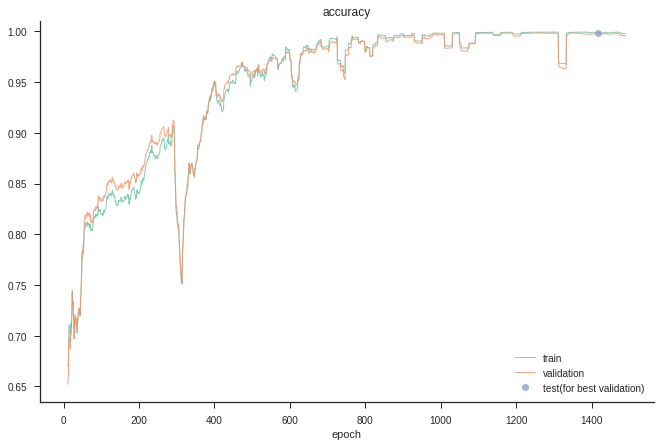

In [23]:
tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'accuracy', smoothing=21)

### Precision/Recall

(<matplotlib.figure.Figure at 0x7f67b2256b70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f67b0a410f0>)

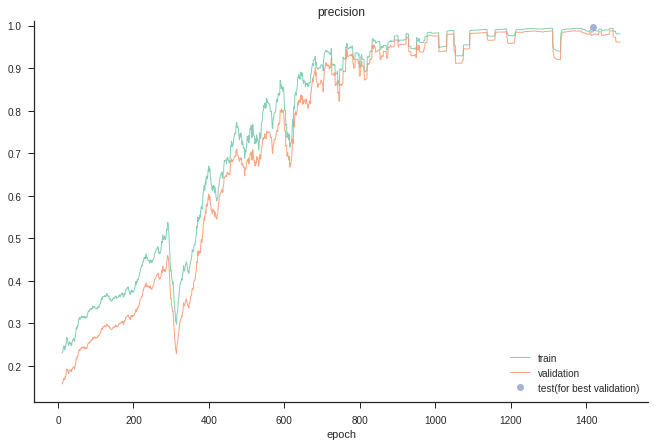

In [24]:
tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'precision', smoothing=21)

(<matplotlib.figure.Figure at 0x7f67b00453c8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f67b01334e0>)

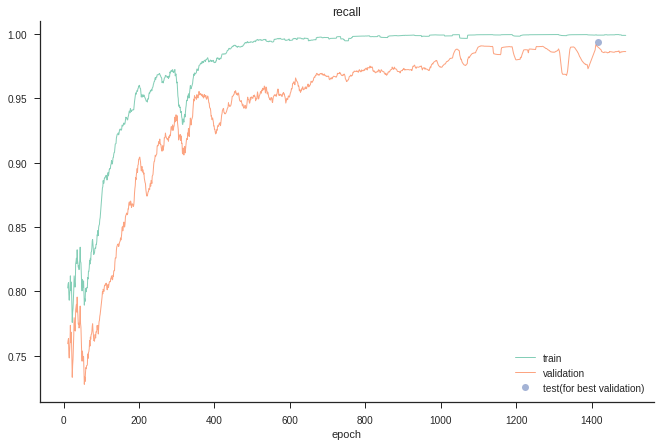

In [25]:
tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'recall', smoothing=21)

### F1-Score

(<matplotlib.figure.Figure at 0x7f67b0c38470>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f67b04f92e8>)

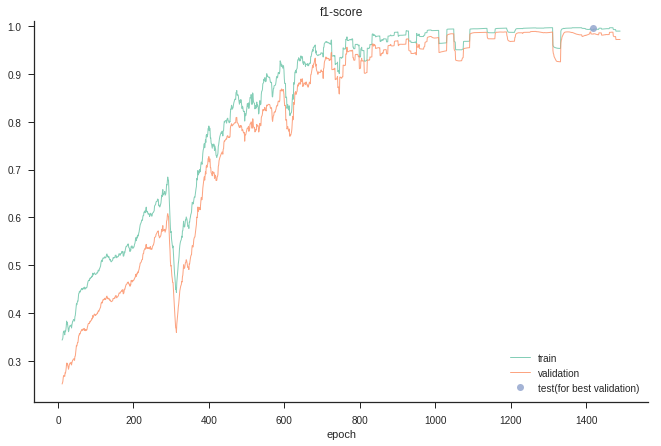

In [26]:
tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'f1-score', smoothing=21)

### Misc stats

In [27]:
# see the best values indxes for validation
validation_stats.idxmax()

accuracy         1416
epoch            1499
f1-score         1416
precision        1451
recall           1321
support             0
support_other       0
dtype: int64

In [28]:
# also, here are the stats averaged over a rolling window of 50, resample in 50 steps
validation_stats.rolling(21, center=True).mean().dropna().iloc[1000::20].drop('epoch', axis=1)

,accuracy,f1-score,precision,recall,support,support_other
1010,0.983368,0.944787,0.938274,0.976747,4106.0,56222.0
1030,0.997244,0.979782,0.977987,0.981606,4106.0,56222.0
1050,0.985396,0.949385,0.938231,0.982743,4106.0,56222.0
1070,0.982694,0.930489,0.913457,0.980435,4106.0,56222.0
1090,0.987862,0.954785,0.945503,0.985608,4106.0,56222.0
1110,0.998117,0.986232,0.981617,0.990896,4106.0,56222.0
1130,0.998231,0.987050,0.983683,0.990444,4106.0,56222.0
1150,0.995992,0.973222,0.965498,0.984135,4106.0,56222.0
1170,0.998290,0.987470,0.984877,0.990084,4106.0,56222.0
1190,0.996776,0.977715,0.970009,0.986976,4106.0,56222.0


In case we need them later, we will persist the results.

In [29]:
pd.concat([train_stats.assign(set='train'), 
           validation_stats.assign(set='validation'), 
           test_stats.assign(set='test')]).to_csv('../data/experimental-results/cleaneval-validation-curves.csv')

## Conclusion
The validation curves look solid, an by looking at the indexes of the beest performanes on the validation set it looks like aroun the 1200-1400 mark, the performance seems to taper off and decrease. The performance is very good, but further confirmation should be done on different splits to have more statistically sound results.

The high similarity between the accuracy and precision could probably be traced to how skewed the dataset is, therefore small changes in performance on the training set would trainslate into changes for the other partitions as well due to the predominance of the negative class.